## Курсовая
**Требования к курсовому:**

Нужно будет оформить ноутбук с основными этапами:
1. подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. обучение модели
3. проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)


________________________
За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline


*Что обязательно стоит попробовать:*
1. Тщательный анализ данных
2. Поиск странных значений
3. Предобработка данных
4. Генерация разнообразных признаков
5. Разные модели и их разные гиперпараметры

*Что не стоит пробовать:*
1. Кластеризация
2. Модели понижения размерности

### [Описание задачи на kaggle](https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/submissions)

### Library import <a class='anchor' id='import'>

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import mode


import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline


# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import random




import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках

In [3]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

[Отбор признаков](#chose_features)

In [4]:
#Создаю датафрейм с результатами для разных моделей. из него буду выбирать максимальное значение r2. 
# и по нему уже вибират лучшую модель
# пока что 2 модели укажу потом дополню

# lr - линейная регрессия
# rf_moel - random forest

results_r2 = pd.DataFrame([[0, 0]], columns=['lr_model', 'rf_moel'])
results_r2

lr_model  rf_moel
0         0        0

### 1. Загрузка данных <a class='anchor' id='load'>

### Data fields

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры


<hr>
<h3 style='text-align: center'> Загружаем тренировочный и тестовый датасеты </h3>
<hr>

In [5]:
# TRAIN DATASET

df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df_train.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.871089  
1         1        1183.0            1        0       B  177734.553407  
2         0         240.0            3        1       B  282078.720850  
3         0           NaN            0        1       B  168106.007630  
4         2           NaN            0        6       B  343995.102962

In [6]:
# TEST DATASET

df_test = pd.read_csv(TEST_DATASET_PATH, sep=',')
df_test.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567          44    1.0  36.847630   19.094182            5.0      5   
1  5925          62    1.0  42.493907   42.568133           10.0      7   
2   960          27    2.0  59.463678         NaN            9.0     19   
3  3848          23    3.0  49.646030   33.893825            6.0      2   
4   746          74    1.0  53.837056         NaN            1.0      8   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1970   0.036122         B         B        24      4378   
1        17.0       2017   0.072158         B         B         2       629   
2        19.0       1977   0.211401         B         B         9      1892   
3         2.0       1965   0.014073         B         B         2       475   
4        17.0       1977   0.309479         B         B        35      7715   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         0        1036.0            1        1       B  
1         1           NaN            0        0       A  
2         0           NaN            0        1       B  
3         0           NaN            0        0       B  
4         4         990.0            0        6       B

In [7]:
# CKECK SHAPE

df_train.shape[1]-1 == df_test.shape[1]

True

### Информация о признаках тренировочного датасета

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

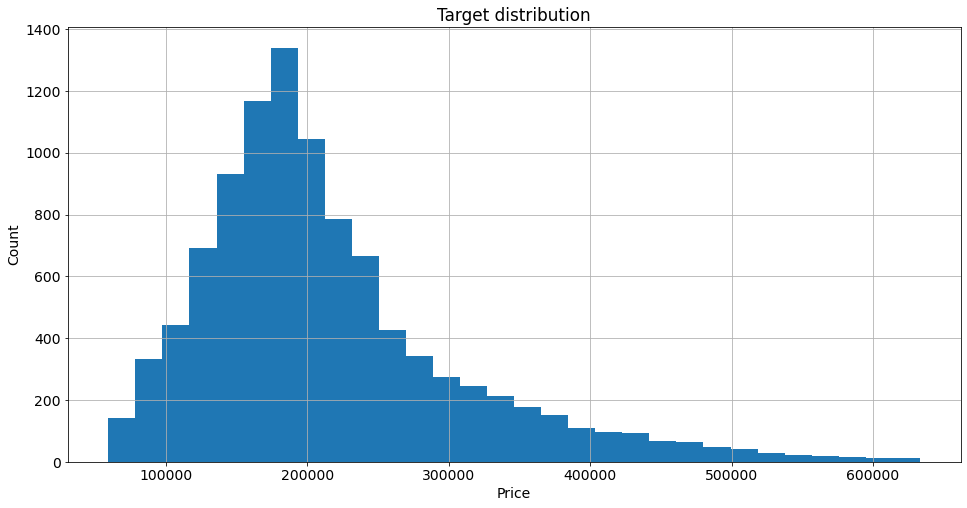

In [9]:
plt.figure(figsize = (16, 8))

df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [10]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)


In [11]:
df_train.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315775    37.199645       6.273300      8.526700   
std        0.839512     21.058732    86.241209      28.560917      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774881    22.769832       1.000000      4.000000   
50%        2.000000     52.513310    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max       19.000000    641.065193  7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

### Информация о признаках тестового датасета

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [13]:
df_test['Id'] = df_test['Id'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

In [14]:
df_test.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  5000.000000  5000.000000  3959.000000    5000.000000  5000.000000   
mean      1.910000    56.449500    36.158810       5.976800     8.632000   
std       0.838594    19.092787    17.825287       9.950018     5.483228   
min       0.000000     1.378543     0.333490       0.000000     1.000000   
25%       1.000000    41.906231    23.092026       1.000000     4.000000   
50%       2.000000    52.921340    32.925087       6.000000     7.000000   
75%       2.000000    66.285129    45.174091       9.000000    12.000000   
max      17.000000   223.453689   303.071094     620.000000    78.000000   

        HouseFloor    HouseYear    Ecology_1     Social_1      Social_2  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean     12.601000  1984.392600     0.119874    24.933800   5406.900000   
std       6.789213    18.573149     0.120070    17.532202   4026.614773   
min       0.000000  1908.000000     0.000000     0.000000    168.000000   
25%       9.000000  1973.000000     0.019509     6.000000   1564.000000   
50%      12.000000  1977.000000     0.072158    25.000000   5285.000000   
75%      17.000000  2000.000000     0.195781    36.000000   7287.000000   
max      99.000000  2020.000000     0.521867    74.000000  19083.000000   

          Social_3  Healthcare_1  Helthcare_2      Shops_1  
count  5000.000000   2623.000000   5000.00000  5000.000000  
mean      8.262600   1146.657263      1.31940     4.242800  
std      23.863762   1044.744231      1.47994     4.777365  
min       0.000000      0.000000      0.00000     0.000000  
25%       0.000000    325.000000      0.00000     1.000000  
50%       2.000000    900.000000      1.00000     3.000000  
75%       5.000000   1548.000000      2.00000     6.000000  
max     141.000000   4849.000000      6.00000    23.000000

Оба датасет имеют пропуски в одних и тех же столбцах.
дальше буду делать обработку и тренировочного и тестового датасета.
будет немного дублирования кода, но т.к. это немного экспериментальная часть, то пока что не буду вытаскивать все в отдельную функцию. возможно отдельную функцию сделаю в конце, как задел н будущее, для обработки такиж датасетов

### категориальные признаки


In [15]:
df_train.select_dtypes(include='object').columns.to_list()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [16]:
df_districtid = df_train['DistrictId'].value_counts()
df_districtid.head(8)

27    851
1     652
23    565
6     511
9     294
62    247
30    228
58    179
Name: DistrictId, dtype: int64

<AxesSubplot:>

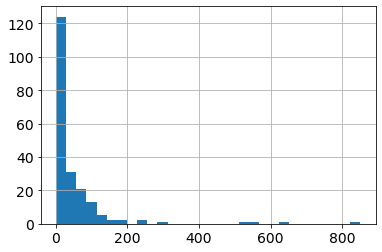

In [17]:
df_districtid.hist(bins=30)

In [18]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [19]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [20]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

<hr>
<h3 style="text-align:center">Обработка выбросов</h3>
<hr>

### Что удалось найти:
+ 1. Есть битые данные в годах, на дворе 2022 год, а там есть значения 4968 и т.д. удалить значения.
+ 2. Есть значения с площадью кухни гораздо больше общей площади. Удалить
+ 3. Есть значения с кол-вом комнат = 0 убрать их
+ 4. есть значения с кол-вом комнат = 10 и 19 убрать их
+ 5. Есть значение, в которых жилая площадь больше общей площади, возможно ошибка в заполнении, поменять местами.
+ 6. Есть значения, в которых площадь кухни больше общей площади. удалить
+ 7. Есть значения, в которых общая площадь меньше 10. убрать ее
+ 8. есть квартира с площадью 7480.592129. удалить
9. в некоторых данных есть очень большой разброс между общей площдью и жилой. в некоторых в десятки раз. возможно это не реальная площадь, а некое отношение площадей. только догадки. может быть при построении модели не стоит учитывать жилую площадь.
10. ошибка в названии одного из столбцов.


<h5> Rooms </h5>

In [21]:
#check Rooms
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

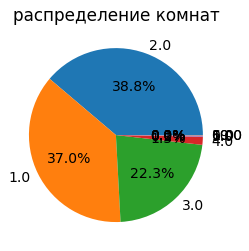

In [22]:
#ради интереса такая картинка.
plt.pie(df_train['Rooms'].value_counts(), 
        labels=df_train['Rooms'].value_counts().index.to_list(), autopct='%1.1f%%')
plt.title("распределение комнат")
plt.show()

In [23]:
# тренировочный датасет
df_train.loc[df_train['Rooms'].isin([0, 10, 19]), 'Rooms'] = df_train['Rooms'].median()

In [24]:
# тестовый датасет
df_test.loc[df_test['Rooms'].isin([0, 10, 19]), 'Rooms'] = df_test['Rooms'].median()

<h6> Square </h6>

In [25]:
df_train['Square'].value_counts().sort_index()

1.136859      1
1.988943      1
2.377248      1
2.596351      1
2.954309      1
             ..
212.932361    1
275.645284    1
409.425181    1
604.705972    1
641.065193    1
Name: Square, Length: 10000, dtype: int64

In [26]:
# тренировочный датасет
df_train = df_train[(df_train['Square'].isnull()) |
         (df_train['Square'] < df_train['Square'].quantile(0.975)) |
         (df_train['Square'] > df_train['Square'].quantile(0.025)) ]

df_train.shape

(10000, 20)

In [27]:
# тестовый датасет
df_test = df_test[(df_test['Square'].isnull()) |
         (df_test['Square'] < df_test['Square'].quantile(0.975)) |
         (df_test['Square'] > df_test['Square'].quantile(0.025)) ]

df_test.shape

(5000, 19)

<h6> LifeSquare </h6>

In [28]:
df_train['LifeSquare'].value_counts().sort_index()

0.370619       1
0.641822       1
0.795539       1
0.873147       1
1.049867       1
              ..
263.542020     1
410.639749     1
461.463614     1
638.163193     1
7480.592129    1
Name: LifeSquare, Length: 7887, dtype: int64

In [29]:
df_train = df_train[(df_train['LifeSquare'].isnull()) |
         (df_train['LifeSquare'] < df_train['LifeSquare'].quantile(0.975)) |
         (df_train['LifeSquare'] > df_train['LifeSquare'].quantile(0.025)) ]

# как работает это условию если у нас логическое или? либо большу 0.025 либо меньше 0.975, это весь диапазон,
# зачем тогда так делать

df_train.shape

(10000, 20)

In [30]:
df_test = df_test[(df_test['LifeSquare'].isnull()) |
         (df_test['LifeSquare'] < df_test['LifeSquare'].quantile(0.975)) |
         (df_test['LifeSquare'] > df_test['LifeSquare'].quantile(0.025)) ]

# как работает это условию если у нас логическое или? либо большу 0.025 либо меньше 0.975, это весь диапазон,
# зачем тогда так делать

df_test.shape

(5000, 19)

<h6> KitchenSquare </h6>

In [31]:
#train dataset
df_train = df_train[(df_train['KitchenSquare'].isnull()) |
         (df_train['KitchenSquare'] < df_train['KitchenSquare'].quantile(0.975)) |
         (df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(0.025)) ]

# в разборе курсовой, тут почему-то нет такой строчки. и каждый раз при выполнении этой ячейки будем обрезать датасет.
# в чем идея?

    
df_train.shape

(10000, 20)

In [32]:
df_train.loc[df_train['KitchenSquare']<3, ['KitchenSquare']] = 3

In [33]:
#test dataset
df_test = df_test[(df_test['KitchenSquare'].isnull()) | 
         (df_test['KitchenSquare'] < df_test['KitchenSquare'].quantile(0.975)) | 
         (df_test['KitchenSquare'] > df_test['KitchenSquare'].quantile(0.025)) ]

    
df_test.shape

(5000, 19)

In [34]:
df_test.loc[df_test['KitchenSquare']<3, ['KitchenSquare']] = 3

<h6> Floor </h6>

In [35]:
df_train['Floor'].sort_values().unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

<h6> HouseFloor </h6>

train dataset

In [36]:
df_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [37]:
df_train['HouseFloor'][df_train['HouseFloor'] == 0] = df_train['HouseFloor'].median()

In [38]:

floor_higher_housefloor = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index

df_train.loc[floor_higher_housefloor, 'Floor'] = df_train.loc[floor_higher_housefloor, 'HouseFloor'].apply(lambda x: random.randint(1,x))




In [39]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index

Int64Index([], dtype='int64')

Test dataset

In [40]:
df_test['HouseFloor'][df_test['HouseFloor'] == 0] = df_test['HouseFloor'].median()

In [41]:
floor_higher_housefloor = df_test.loc[df_test['Floor'] > df_test['HouseFloor']].index

df_test.loc[floor_higher_housefloor, 'Floor'] = df_test.loc[floor_higher_housefloor, 'HouseFloor'].apply(lambda x: random.randint(1,x))



In [42]:
df_test.loc[df_test['Floor'] > df_test['HouseFloor']].index

Int64Index([], dtype='int64')

<h6> HouseYear </h6>


In [43]:
df_train['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [44]:
df_train['HouseYear'][df_train['HouseYear'] > 2022] = 2022

In [45]:
df_test['HouseYear'][df_test['HouseYear'] > 2022] = 2022

<hr>
<h3 style="text-align:center">Обработка пустых данных</h3>
<hr>

In [46]:
df_train.isna().sum()
#значения отличаются от разбора, любопытно

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [47]:
df_train[['Square','LifeSquare','KitchenSquare']].head(10)

Square  LifeSquare  KitchenSquare
0  115.027311         NaN           10.0
1   39.832524   23.169223            8.0
2   78.342215   47.671972           10.0
3   40.409907         NaN            3.0
4   64.285067   38.562517            9.0
5   62.528465   47.103833            6.0
6   33.938750   21.772930            9.0
7   50.391814   32.893256            8.0
8   46.887892   44.628132            3.0
9   79.867477   75.085125            3.0

<h6> LifeSquare </h6>

train data

In [48]:
df_train['LifeSquare'].median()

32.781260192155735

In [49]:
square_diff_mediana = (df_train['Square'][df_train['LifeSquare'].notnull()]
                       - df_train['LifeSquare'][df_train['LifeSquare'].notnull()]
                       - df_train['KitchenSquare'][df_train['LifeSquare'].notnull()]).median()

square_diff_mediana

11.361443422298542

In [50]:
df_train['LifeSquare'][df_train['LifeSquare'].isnull()] = df_train['Square'][df_train['LifeSquare'].isnull()] -\
                                                          df_train['KitchenSquare'][df_train['LifeSquare'].isnull()] - \
                                                          square_diff_mediana

In [51]:
df_train['LifeSquare'].median()

33.781535552542216

### test data
для тестовых данных подставлю значение square_diff_mediana полученное из тренировочных

In [52]:
df_test['LifeSquare'].median()

32.92508663208161

In [53]:
df_test['LifeSquare'][df_test['LifeSquare'].isnull()] = df_test['Square'][df_test['LifeSquare'].isnull()] -\
                                                          df_test['KitchenSquare'][df_test['LifeSquare'].isnull()] - \
                                                          square_diff_mediana

In [54]:
df_test['LifeSquare'].median()

34.07274220544646

значение медианы практически не изменилось

<h6> Healthcare_1 </h6> 

In [55]:
df_train['Healthcare_1'][df_train['Healthcare_1'].isnull()] = df_train['Healthcare_1'].median()

In [56]:
#проверка
df_train.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [57]:
df_test['Healthcare_1'][df_test['Healthcare_1'].isnull()] = df_test['Healthcare_1'].median()

In [58]:
df_test.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

<hr>
<h3 style="text-align:center">Построение новых признаков</h3>
<hr>

In [59]:
#'Ecology_2', 'Ecology_3', 'Shops_2'
df_train['Ecology_2_bin'] = df_train['Ecology_2'].replace({'A': 0, 'B': 1})
df_train['Ecology_3_bin'] = df_train['Ecology_3'].replace({'A': 0, 'B': 1})
df_train['Shops_2_bin'] = df_train['Shops_2'].replace({'A': 0, 'B': 1})

df_test['Ecology_2_bin'] = df_test['Ecology_2'].replace({'A': 0, 'B': 1})
df_test['Ecology_3_bin'] = df_test['Ecology_3'].replace({'A': 0, 'B': 1})
df_test['Shops_2_bin'] = df_test['Shops_2'].replace({'A': 0, 'B': 1})

<h6> Distict size </h6> 

In [60]:
distict_size = df_train['DistrictId'].value_counts().reset_index().\
                                    rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
distict_size

DistrictId  DistrictSize
0           27           851
1            1           652
2           23           565
3            6           511
4            9           294
..         ...           ...
200        199             1
201        117             1
202        207             1
203        209             1
204        174             1

[205 rows x 2 columns]

In [61]:
df_train = df_train.merge(distict_size, on='DistrictId', how='left')
df_train.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  115.027311   93.665867           10.0      4   
1   3013         22    1.0   39.832524   23.169223            8.0      7   
2   8215          1    3.0   78.342215   47.671972           10.0      2   
3   2352          1    1.0   40.409907   26.048463            3.0     10   
4  13866         94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ... Social_3 Healthcare_1  Helthcare_2  \
0        10.0       2014   0.075424  ...        0        900.0            0   
1         8.0       1966   0.118537  ...        1       1183.0            1   
2        17.0       1988   0.025609  ...        0        240.0            3   
3        22.0       1977   0.007122  ...        0        900.0            0   
4        16.0       1972   0.282798  ...        2        900.0            0   

   Shops_1  Shops_2          Price  Ecology_2_bin  Ecology_3_bin Shops_2_bin  \
0        0        B  305018.871089              1              1           1   
1        0        B  177734.553407              1              1           1   
2        1        B  282078.720850              1              1           1   
3        1        B  168106.007630              1              1           1   
4        6        B  343995.102962              1              1           1   

   DistrictSize  
0           851  
1            78  
2           652  
3           652  
4            89  

[5 rows x 24 columns]

In [62]:
df_test = df_test.merge(distict_size, on='DistrictId', how='left')
df_test.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567         44    1.0  36.847630   19.094182            5.0      5   
1  5925         62    1.0  42.493907   42.568133           10.0      7   
2   960         27    2.0  59.463678   39.102235            9.0     19   
3  3848         23    3.0  49.646030   33.893825            6.0      2   
4   746         74    1.0  53.837056   39.475612            3.0      8   

   HouseFloor  HouseYear  Ecology_1  ... Social_2 Social_3  Healthcare_1  \
0         9.0       1970   0.036122  ...     4378        0        1036.0   
1        17.0       2017   0.072158  ...      629        1         900.0   
2        19.0       1977   0.211401  ...     1892        0         900.0   
3         2.0       1965   0.014073  ...      475        0         900.0   
4        17.0       1977   0.309479  ...     7715        4         990.0   

   Helthcare_2  Shops_1  Shops_2  Ecology_2_bin  Ecology_3_bin Shops_2_bin  \
0            1        1        B              1              1           1   
1            0        0        A              1              1           0   
2            0        1        B              1              1           1   
3            0        0        B              1              1           1   
4            0        6        B              1              1           1   

   DistrictSize  
0         104.0  
1         247.0  
2         851.0  
3         565.0  
4         114.0  

[5 rows x 23 columns]

In [63]:
(df_train['DistrictSize']>100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

<h6> IsDistrictLarge </h6> 

In [64]:
df_train['IsDistrictLarge'] = (df_train['DistrictSize']>100).astype(int)

In [65]:
df_test['IsDistrictLarge'] = (df_test['DistrictSize']>100).astype(int)

<h6> MedianPriceByDistric </h6> 

In [66]:
median_price_by_district = df_train.groupby(['DistrictId','Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedianPriceByDistric'})

median_price_by_district


DistrictId  Rooms  MedianPriceByDistric
0            0    1.0         142799.434052
1            0    2.0         176210.812334
2            0    3.0         300610.359425
3            1    1.0         146735.671740
4            1    2.0         202666.310126
..         ...    ...                   ...
663         98    4.0         450946.459365
664         99    1.0         158539.052715
665         99    2.0         187254.720362
666         99    3.0         223960.229617
667         99    6.0         229661.964416

[668 rows x 3 columns]

In [67]:
df_train = df_train.merge(median_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_train.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  115.027311   93.665867           10.0      4   
1   3013         22    1.0   39.832524   23.169223            8.0      7   
2   8215          1    3.0   78.342215   47.671972           10.0      2   
3   2352          1    1.0   40.409907   26.048463            3.0     10   
4  13866         94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ... Helthcare_2 Shops_1  Shops_2  \
0        10.0       2014   0.075424  ...           0       0        B   
1         8.0       1966   0.118537  ...           1       0        B   
2        17.0       1988   0.025609  ...           3       1        B   
3        22.0       1977   0.007122  ...           0       1        B   
4        16.0       1972   0.282798  ...           0       6        B   

           Price  Ecology_2_bin  Ecology_3_bin  Shops_2_bin  DistrictSize  \
0  305018.871089              1              1            1           851   
1  177734.553407              1              1            1            78   
2  282078.720850              1              1            1           652   
3  168106.007630              1              1            1           652   
4  343995.102962              1              1            1            89   

  IsDistrictLarge  MedianPriceByDistric  
0               1         213530.788443  
1               0         146032.829834  
2               1         244005.272380  
3               1         146735.671740  
4               0         201584.441255  

[5 rows x 26 columns]

In [68]:
df_test = df_test.merge(median_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_test.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567         44    1.0  36.847630   19.094182            5.0      5   
1  5925         62    1.0  42.493907   42.568133           10.0      7   
2   960         27    2.0  59.463678   39.102235            9.0     19   
3  3848         23    3.0  49.646030   33.893825            6.0      2   
4   746         74    1.0  53.837056   39.475612            3.0      8   

   HouseFloor  HouseYear  Ecology_1  ... Healthcare_1 Helthcare_2  Shops_1  \
0         9.0       1970   0.036122  ...       1036.0           1        1   
1        17.0       2017   0.072158  ...        900.0           0        0   
2        19.0       1977   0.211401  ...        900.0           0        1   
3         2.0       1965   0.014073  ...        900.0           0        0   
4        17.0       1977   0.309479  ...        990.0           0        6   

   Shops_2  Ecology_2_bin  Ecology_3_bin  Shops_2_bin  DistrictSize  \
0        B              1              1            1         104.0   
1        A              1              1            0         247.0   
2        B              1              1            1         851.0   
3        B              1              1            1         565.0   
4        B              1              1            1         114.0   

  IsDistrictLarge  MedianPriceByDistric  
0               1         171145.169069  
1               1         129107.218932  
2               1         165700.355193  
3               1         166687.735824  
4               1         165071.825722  

[5 rows x 25 columns]

<h6>MedianPriceForOneSquareMeter</h6>

медианная цена одного квадратного метра по региону. 
делю цену на площадь.
затем это групприую по региону и вычисляю медиану.

данную штуку прикручу как тренировочному датасету, так и к тестовому.

т.к. у нас есть данные о цене на тренировочной выборке, то думаю это нормально, эти данные добавить в тестовую выборку.
столбец смержить по столбцу дистрикт ID

In [69]:
median_price_for_one_square_meter = pd.DataFrame(df_train.loc[:,['Square', 'DistrictId', 'Rooms','Price']], columns = ['Square', 'DistrictId','Rooms', 'Price'])
median_price_for_one_square_meter['1_meter_price'] =  median_price_for_one_square_meter['Price']/median_price_for_one_square_meter['Square']
median_price_for_one_square_meter

Square DistrictId  Rooms          Price  1_meter_price
0     115.027311         27    3.0  305018.871089    2651.708272
1      39.832524         22    1.0  177734.553407    4462.045990
2      78.342215          1    3.0  282078.720850    3600.596698
3      40.409907          1    1.0  168106.007630    4160.019670
4      64.285067         94    2.0  343995.102962    5351.088794
...          ...        ...    ...            ...            ...
9995   49.090728         61    2.0  119367.455796    2431.568231
9996   64.307684         27    2.0  199715.148807    3105.618729
9997   29.648057        178    1.0  165953.912580    5597.463388
9998   32.330292         21    1.0  171842.411855    5315.213665
9999   35.815476         94    1.0  177685.627486    4961.140965

[10000 rows x 5 columns]

In [70]:
median_price_for_one_square_meter['1_meter_price'].median()

3910.0523359988283

In [71]:
one_meter_price_by_district = median_price_for_one_square_meter.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'1_meter_price':'median'})\
                            .rename(columns={'1_meter_price':'one_meter_price_by_district'})

In [72]:
one_meter_price_by_district.head(9)

DistrictId  Rooms  one_meter_price_by_district
0          0    1.0                  4014.374409
1          0    2.0                  3697.857111
2          0    3.0                  4405.321283
3          1    1.0                  3427.367727
4          1    2.0                  3205.262775
5          1    3.0                  3001.168657
6          1    4.0                  2775.876994
7         10    1.0                  4747.011353
8         10    2.0                  4528.009395

In [73]:
df_train = df_train.merge(one_meter_price_by_district, on=['DistrictId','Rooms'], how='left')
df_train.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  115.027311   93.665867           10.0      4   
1   3013         22    1.0   39.832524   23.169223            8.0      7   
2   8215          1    3.0   78.342215   47.671972           10.0      2   
3   2352          1    1.0   40.409907   26.048463            3.0     10   
4  13866         94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ... Shops_1 Shops_2          Price  \
0        10.0       2014   0.075424  ...       0       B  305018.871089   
1         8.0       1966   0.118537  ...       0       B  177734.553407   
2        17.0       1988   0.025609  ...       1       B  282078.720850   
3        22.0       1977   0.007122  ...       1       B  168106.007630   
4        16.0       1972   0.282798  ...       6       B  343995.102962   

   Ecology_2_bin  Ecology_3_bin  Shops_2_bin  DistrictSize  IsDistrictLarge  \
0              1              1            1           851                1   
1              1              1            1            78                0   
2              1              1            1           652                1   
3              1              1            1           652                1   
4              1              1            1            89                0   

  MedianPriceByDistric  one_meter_price_by_district  
0        213530.788443                  2790.801287  
1        146032.829834                  3680.061716  
2        244005.272380                  3001.168657  
3        146735.671740                  3427.367727  
4        201584.441255                  4289.674901  

[5 rows x 27 columns]

In [74]:
df_test = df_test.merge(one_meter_price_by_district, on=['DistrictId','Rooms'], how='left')
df_test.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567         44    1.0  36.847630   19.094182            5.0      5   
1  5925         62    1.0  42.493907   42.568133           10.0      7   
2   960         27    2.0  59.463678   39.102235            9.0     19   
3  3848         23    3.0  49.646030   33.893825            6.0      2   
4   746         74    1.0  53.837056   39.475612            3.0      8   

   HouseFloor  HouseYear  Ecology_1  ... Helthcare_2 Shops_1  Shops_2  \
0         9.0       1970   0.036122  ...           1       1        B   
1        17.0       2017   0.072158  ...           0       0        A   
2        19.0       1977   0.211401  ...           0       1        B   
3         2.0       1965   0.014073  ...           0       0        B   
4        17.0       1977   0.309479  ...           0       6        B   

   Ecology_2_bin  Ecology_3_bin  Shops_2_bin  DistrictSize  IsDistrictLarge  \
0              1              1            1         104.0                1   
1              1              1            0         247.0                1   
2              1              1            1         851.0                1   
3              1              1            1         565.0                1   
4              1              1            1         114.0                1   

  MedianPriceByDistric  one_meter_price_by_district  
0        171145.169069                  4806.416257  
1        129107.218932                  2763.143194  
2        165700.355193                  2574.064003  
3        166687.735824                  2105.548938  
4        165071.825722                  3404.238545  

[5 rows x 26 columns]

<h6>MedianPriceBySquare</h6>
Данный параметр был предложен в разборе курсовой. но я не понял, как он работает и какую информацию дает.
и тем более как его прикрутить к тестовому датасету. т.к. площади совершенно разные и не совпадают.
поэтому просто закоментирую

In [75]:
# median_price_by_square = df_train.groupby(['Square'], as_index=False).agg({'Price':'median'})\
#                             .rename(columns={'Price':'MedianPriceBySquare'})

# median_price_by_square.head()

In [76]:
# df_test.head()

In [77]:
# df_test = df_test.merge(median_price_by_square, on=['Square'], how='left')
# df_test.head()

In [78]:
# зачем это делается, если нет никаких совпадений? везде флоаты
# и весь столбец пустой

# df_test.info()

<h6>Сохраняю в файл</h6>

In [79]:
df_train.to_csv('./train_prepared_data.csv', index=False, encoding='utf-8')

In [80]:
df_test.to_csv('./gonin_test_prepared_data.csv', index=False, encoding='utf-8')

In [81]:
target_mean = round(df_train.Price.mean(), 2)
target_median = df_train.Price.median()
target_mode = df_train.Price.mode()[0]

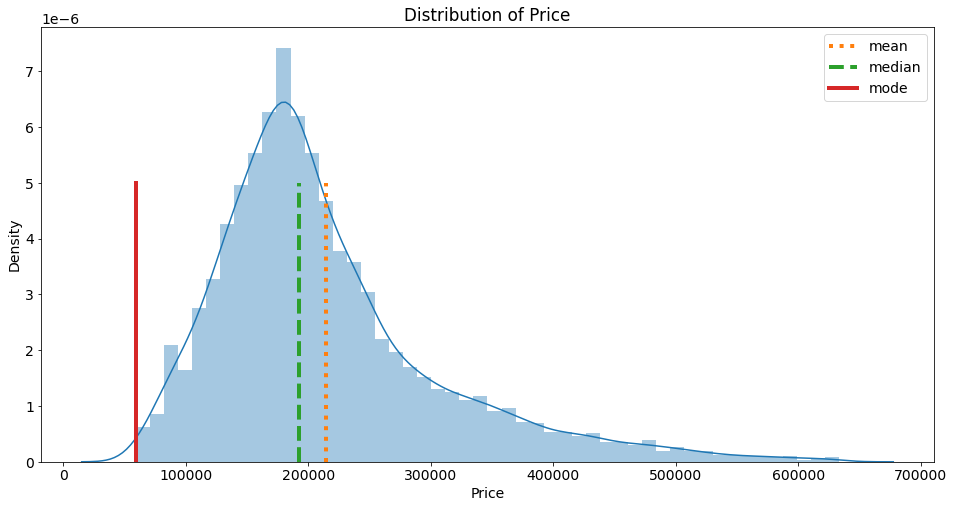

In [82]:
plt.figure(figsize = (16, 8))

sns.distplot(df_train.Price, bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

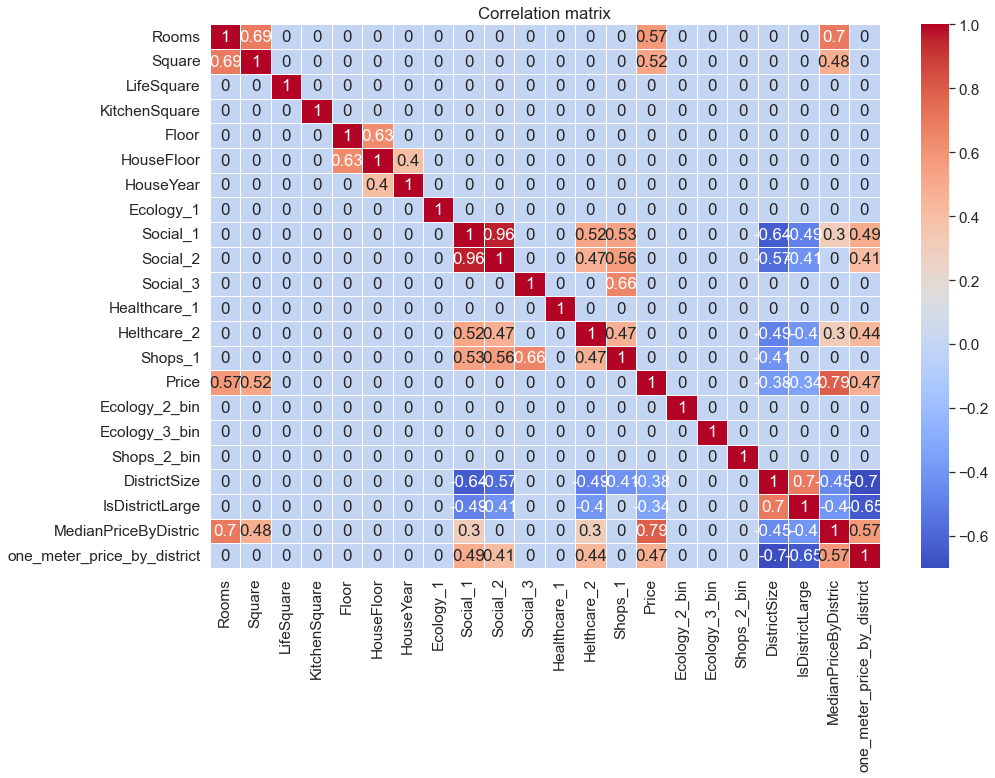

In [83]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

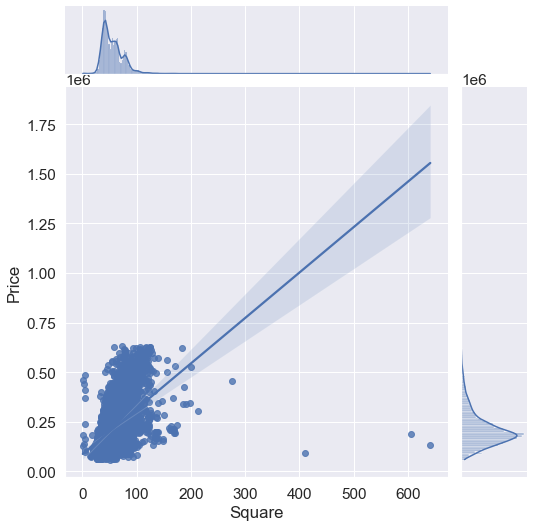

In [84]:
grid2 = sns.jointplot(df_train['Square'], df_train['Price'], kind='reg')
grid2.fig.set_figwidth(8)
grid2.fig.set_figheight(8)


plt.show()

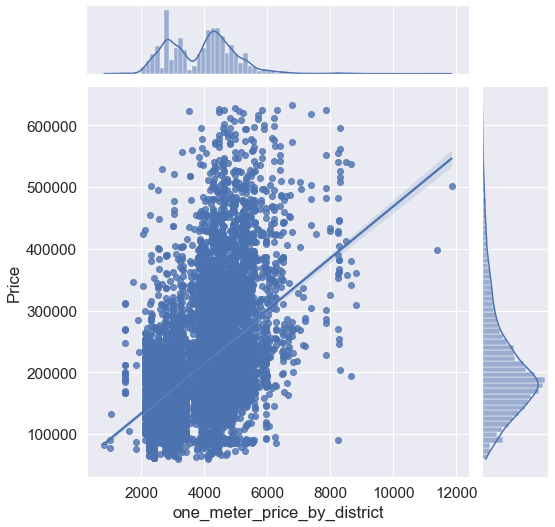

In [85]:
# df_train_cut = df_train[(df_train['Square']>30) & (df_train['Square']<50)]
grid2 = sns.jointplot(df_train['one_meter_price_by_district'], df_train['Price'], kind='reg')
grid2.fig.set_figwidth(8)
grid2.fig.set_figheight(8)

plt.show()

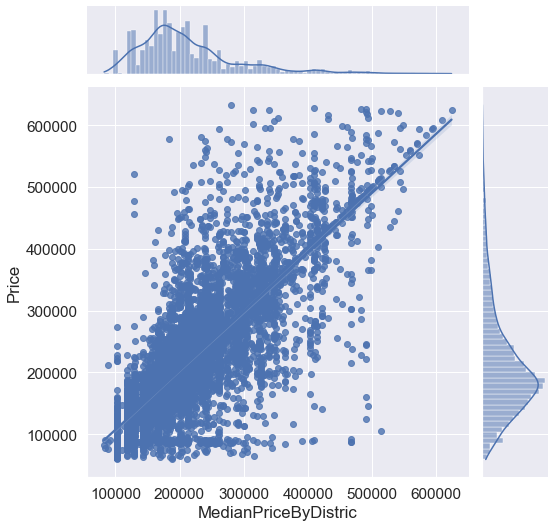

In [86]:
# df_train_cut = df_train[(df_train['Square']>50) & (df_train['Square']<70)]
grid2 = sns.jointplot(df_train['MedianPriceByDistric'], df_train['Price'], kind='reg')
grid2.fig.set_figwidth(8)
grid2.fig.set_figheight(8)

plt.show()

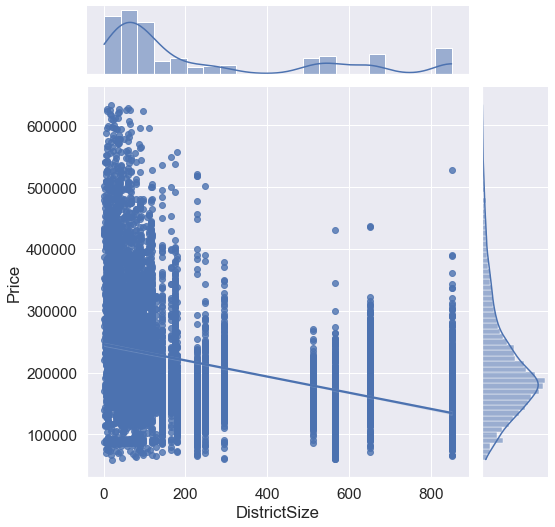

In [87]:
grid2 = sns.jointplot(df_train['DistrictSize'], df_train['Price'], kind='reg')
grid2.fig.set_figwidth(8)
grid2.fig.set_figheight(8)

plt.show()

<hr>
<a id='chose_features'></a>
<h3 style="text-align:center">Отбор признаков</h3>
<hr>

In [88]:
def check_model(model, features_list, xTrain, yTrain, Xtest, yTest):
    
    model.fit(xTrain.loc[:, features_list], y_train)
    yPred = model.predict(Xtest.loc[:, features_list])

    r2_result = round(r2(yTest, yPred), 3)
    print("R2:\t" + str(r2_result) + "\n")
    

    yPred = np.clip(yPred, a_min=10000, a_max=500000)

    plt.figure(figsize=(8,8))
    sns.scatterplot(x=yTest, y=yPred)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    plt.show()
    
    return r2_result

In [89]:
# это чтобы не повторять заново все шаги по обработке данных
df_train = pd.read_csv('./train_prepared_data.csv')
df_train.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311   93.665867           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907   26.048463            3.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ... Shops_1 Shops_2          Price  \
0        10.0       2014   0.075424  ...       0       B  305018.871089   
1         8.0       1966   0.118537  ...       0       B  177734.553407   
2        17.0       1988   0.025609  ...       1       B  282078.720850   
3        22.0       1977   0.007122  ...       1       B  168106.007630   
4        16.0       1972   0.282798  ...       6       B  343995.102962   

   Ecology_2_bin  Ecology_3_bin  Shops_2_bin  DistrictSize  IsDistrictLarge  \
0              1              1            1           851                1   
1              1              1            1            78                0   
2              1              1            1           652                1   
3              1              1            1           652                1   
4              1              1            1            89                0   

  MedianPriceByDistric  one_meter_price_by_district  
0        213530.788443                  2790.801287  
1        146032.829834                  3680.061716  
2        244005.272380                  3001.168657  
3        146735.671740                  3427.367727  
4        201584.441255                  4289.674901  

[5 rows x 27 columns]

In [90]:
df_train.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedianPriceByDistric',
 'one_meter_price_by_district']

In [91]:
feature_names = ['Rooms', 'Floor', 'HouseFloor', 'HouseYear',\
                 'Square', 'LifeSquare', 'KitchenSquare', \
                 'Ecology_1', 'Ecology_2_bin','Ecology_3_bin',\
                 'Social_1', 'Social_2', 'Social_3',\
                 'Healthcare_1', 'Helthcare_2',\
                 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedianPriceByDistric']

feature_names_all = ['Rooms', 'Floor', 'HouseFloor', 'HouseYear',\
                 'Square', 'LifeSquare', 'KitchenSquare', \
                 'Ecology_1', 'Ecology_2_bin','Ecology_3_bin',\
                 'Social_1', 'Social_2', 'Social_3',\
                 'Healthcare_1', 'Helthcare_2',\
                 'Shops_1', 'Shops_2_bin',
                 'IsDistrictLarge', 'MedianPriceByDistric', 'one_meter_price_by_district'  ]

target_name = 'Price'

In [92]:
df_train[feature_names_all]

Rooms  Floor  HouseFloor  HouseYear      Square  LifeSquare  \
0       3.0      4        10.0       2014  115.027311   93.665867   
1       1.0      7         8.0       1966   39.832524   23.169223   
2       3.0      2        17.0       1988   78.342215   47.671972   
3       1.0     10        22.0       1977   40.409907   26.048463   
4       2.0     16        16.0       1972   64.285067   38.562517   
...     ...    ...         ...        ...         ...         ...   
9995    2.0      3        12.0       1981   49.090728   33.272626   
9996    2.0     13        13.0       1977   64.307684   37.038420   
9997    1.0      3         5.0       1958   29.648057   16.555363   
9998    1.0      3         9.0       1969   32.330292   22.326870   
9999    1.0      9         9.0       1975   35.815476   22.301367   

      KitchenSquare  Ecology_1  Ecology_2_bin  Ecology_3_bin  Social_1  \
0              10.0   0.075424              1              1        11   
1               8.0   0.118537              1              1        30   
2              10.0   0.025609              1              1        33   
3               3.0   0.007122              1              1         1   
4               9.0   0.282798              1              1        33   
...             ...        ...            ...            ...       ...   
9995            6.0   0.300323              1              1        52   
9996            9.0   0.072158              1              1         2   
9997            5.0   0.460556              1              1        20   
9998            5.0   0.194489              1              1        47   
9999            6.0   0.127376              1              1        43   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2_bin  \
0         3097         0         900.0            0        0            1   
1         6207         1        1183.0            1        0            1   
2         5261         0         240.0            3        1            1   
3          264         0         900.0            0        1            1   
4         8667         2         900.0            0        6            1   
...        ...       ...           ...          ...      ...          ...   
9995     10311         6         900.0            1        9            1   
9996       629         1         900.0            0        0            0   
9997      4386        14         900.0            1        5            1   
9998      8004         3         125.0            3        5            1   
9999      8429         3         900.0            3        9            1   

      IsDistrictLarge  MedianPriceByDistric  one_meter_price_by_district  
0                   1         213530.788443                  2790.801287  
1                   0         146032.829834                  3680.061716  
2                   1         244005.272380                  3001.168657  
3                   1         146735.671740                  3427.367727  
4                   0         201584.441255                  4289.674901  
...               ...                   ...                          ...  
9995                1         232514.855623                  4732.035885  
9996                1         165700.355193                  2574.064003  
9997                0         165953.912580                  5597.463388  
9998                1         153921.400690                  4357.135431  
9999                0         158830.639873                  4273.743805  

[10000 rows x 20 columns]

In [93]:
df_train[feature_names_all].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Rooms                        10000 non-null  float64
 1   Floor                        10000 non-null  int64  
 2   HouseFloor                   10000 non-null  float64
 3   HouseYear                    10000 non-null  int64  
 4   Square                       10000 non-null  float64
 5   LifeSquare                   10000 non-null  float64
 6   KitchenSquare                10000 non-null  float64
 7   Ecology_1                    10000 non-null  float64
 8   Ecology_2_bin                10000 non-null  int64  
 9   Ecology_3_bin                10000 non-null  int64  
 10  Social_1                     10000 non-null  int64  
 11  Social_2                     10000 non-null  int64  
 12  Social_3                     10000 non-null  int64  
 13  Healthcare_1     

In [94]:
X = df_train[feature_names_all]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=15)

<h6>Линейная модель</h6>

In [95]:
scaler = StandardScaler()

In [96]:
X_train_scaled = scaler.fit_transform(X_train)

In [97]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.head()

Rooms     Floor  HouseFloor  HouseYear    Square  LifeSquare  \
0 -1.092069  1.892649    1.842253  -0.969673 -1.239124   -0.303967   
1  0.130396 -1.264265   -1.827695  -0.431958  0.396590   -0.378013   
2 -1.092069  0.906113   -0.145636   0.105758 -0.409084   -0.203741   
3 -1.092069 -1.264265   -1.216037  -1.346074 -0.472475   -0.172991   
4 -1.092069 -0.672344   -0.604379  -0.163100 -0.928557   -0.191215   

   KitchenSquare  Ecology_1  Ecology_2_bin  Ecology_3_bin  Social_1  Social_2  \
0       0.026760  -0.386625       0.103835       0.163813 -1.295575 -1.178989   
1      -0.125910   0.365808       0.103835       0.163813  0.010494  0.066867   
2       0.026760   0.907086      -9.630680       0.163813  0.919064  0.292755   
3       0.026760   0.369545       0.103835      -6.104532  0.351208  0.404954   
4      -0.034308  -0.647888       0.103835       0.163813  1.202992  1.026765   

   Social_3  Healthcare_1  Helthcare_2   Shops_1  Shops_2_bin  \
0 -0.292879     -0.171640    -0.887813 -0.885180    -3.282368   
1 -0.292879     -1.346583     0.442045 -0.053895     0.304658   
2 -0.039514      0.703490     1.106974 -0.469538     0.304658   
3 -0.123969      4.700997     1.106974  0.569569     0.304658   
4 -0.123969     -0.171640    -0.222884  1.193033     0.304658   

   IsDistrictLarge  MedianPriceByDistric  one_meter_price_by_district  
0         0.989917             -1.215961                    -1.038044  
1         0.989917             -0.315059                    -0.725021  
2        -1.010185             -0.780181                     0.526944  
3        -1.010185             -0.098496                     1.356744  
4        -1.010185             -0.068739                     1.193937

In [98]:
X_test_scaled = scaler.fit_transform(X_test)

In [99]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled.head()

Rooms     Floor  HouseFloor  HouseYear    Square  LifeSquare  \
0  1.417087  0.540386    0.654361   0.090088  1.125330    0.486798   
1 -1.102627  0.336744    0.328873  -0.414012 -0.888521   -1.063622   
2  0.157230  0.336744   -0.647591  -0.918112 -0.634021   -0.374050   
3  0.157230 -0.885113    0.654361   0.762222 -0.113265   -0.369961   
4 -1.102627  2.984099    1.956313  -0.414012 -0.263048   -0.069818   

   KitchenSquare  Ecology_1  Ecology_2_bin  Ecology_3_bin  Social_1  Social_2  \
0       0.824025   0.078783       0.082744       0.180641  0.850121  1.306252   
1       0.824025  -0.409593       0.082744       0.180641 -1.289989 -1.178941   
2      -0.600145   0.812447       0.082744       0.180641 -0.191013 -0.203295   
3       0.349302  -1.012397       0.082744       0.180641  0.329554  0.073430   
4      -0.837507  -0.409593       0.082744       0.180641 -1.289989 -1.178941   

   Social_3  Healthcare_1  Helthcare_2   Shops_1  Shops_2_bin  \
0  0.026797     -0.162336    -0.186462  1.013556     0.285158   
1 -0.302815     -0.162336    -0.870976 -0.866185    -3.506832   
2 -0.096807      0.556792     1.867082  0.595836    -3.506832   
3 -0.344017     -0.162336    -0.870976  0.178116    -3.506832   
4 -0.302815     -0.162336    -0.870976 -0.866185    -3.506832   

   IsDistrictLarge  MedianPriceByDistric  one_meter_price_by_district  
0        -1.025115              1.485010                     0.531368  
1         0.975500             -1.078350                    -1.089446  
2        -1.025115              0.236498                     0.595291  
3        -1.025115              0.326334                     0.178036  
4         0.975500             -1.222449                    -1.016573

In [100]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

R2:	0.69



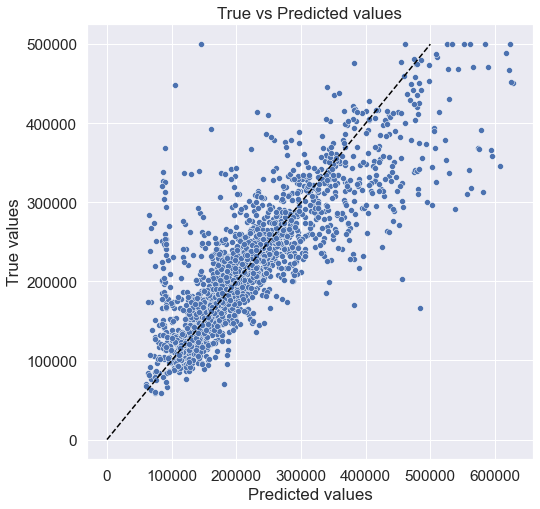

In [101]:
results_r2['lr_model'] = check_model(LinearRegression(),\
                                     feature_names_all, \
                                     X_train_scaled, \
                                     y_train, \
                                     X_test_scaled, \
                                     y_test)

In [102]:
results_r2

lr_model  rf_moel
0      0.69        0

Text(0, 0.5, 'Признак')

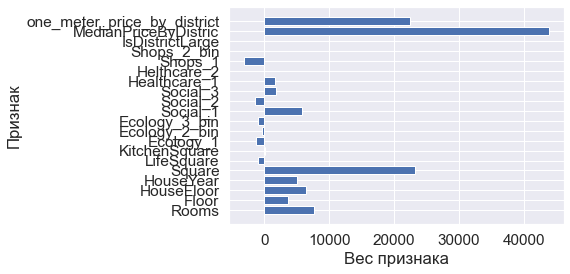

In [103]:
plt.barh(X_train_scaled.columns, lr_model.coef_.flatten())
plt.xlabel('Вес признака')
plt.ylabel('Признак')

In [104]:
X_train_scaled.columns

Index(['Rooms', 'Floor', 'HouseFloor', 'HouseYear', 'Square', 'LifeSquare',
       'KitchenSquare', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2_bin', 'IsDistrictLarge', 'MedianPriceByDistric',
       'one_meter_price_by_district'],
      dtype='object')

In [105]:
lr_new_feature_names = ['Rooms', 'Floor', 'HouseFloor', 'HouseYear', 'Square', 'LifeSquare',
       'KitchenSquare','Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Shops_1','IsDistrictLarge', 'MedianPriceByDistric','one_meter_price_by_district']

R2:	0.69



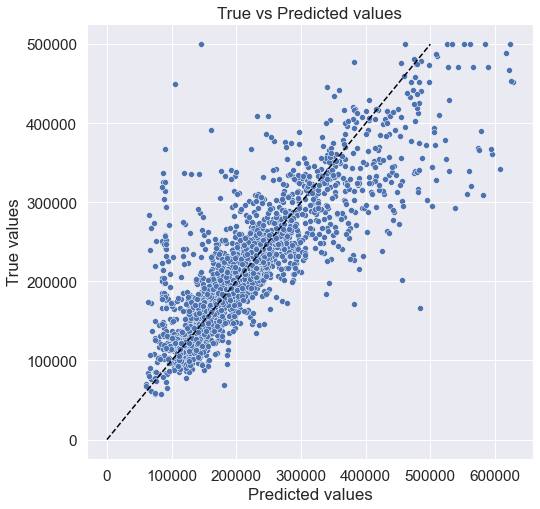

In [106]:
results_r2['lr_model_2'] = check_model(LinearRegression(), \
                                       lr_new_feature_names, \
                                       X_train_scaled, \
                                       y_train, \
                                       X_test_scaled, \
                                       y_test)


In [107]:
results_r2

lr_model  rf_moel  lr_model_2
0      0.69        0        0.69

##### Lasso

R2:	0.69



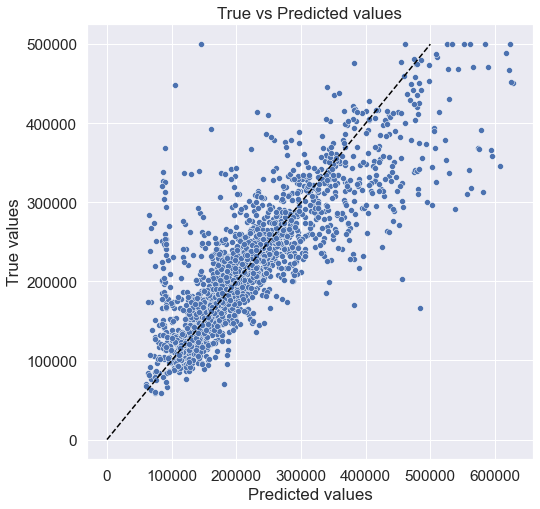

In [108]:
results_r2['lasso'] = check_model(Lasso(alpha=0.003), \
                                   feature_names_all, \
                                   X_train_scaled, \
                                   y_train, \
                                   X_test_scaled, \
                                   y_test)

##### Ridge

R2:	0.69



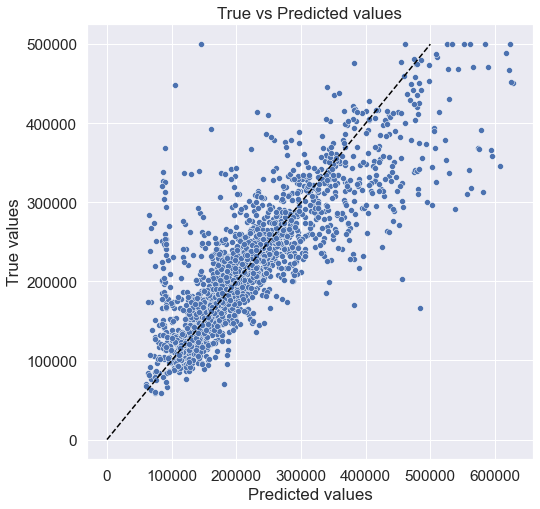

In [109]:
results_r2['ridge'] = check_model(Ridge(alpha=0.001), \
                                   feature_names_all, \
                                   X_train_scaled, \
                                   y_train, \
                                   X_test_scaled, \
                                   y_test)

In [110]:
results_r2

lr_model  rf_moel  lr_model_2  lasso  ridge
0      0.69        0        0.69   0.69   0.69

<h6>DecisionTree</h6>

2
R2:	0.532



3
R2:	0.604



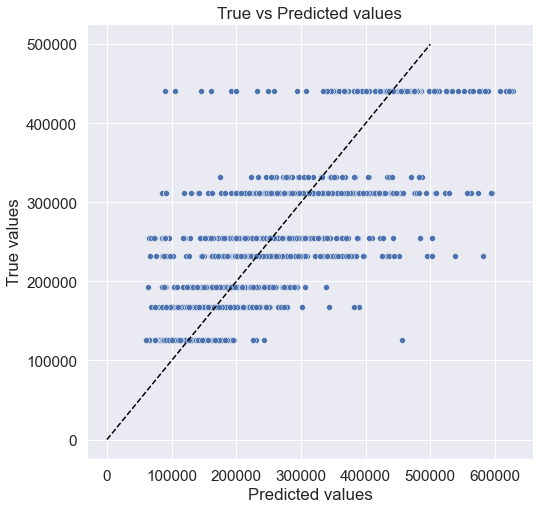

4
R2:	0.634



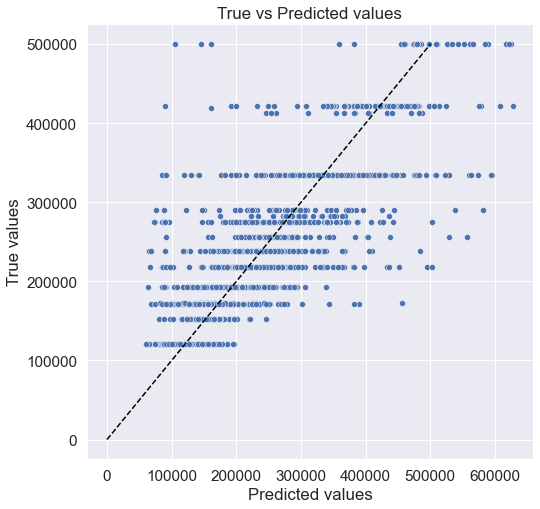

5
R2:	0.65



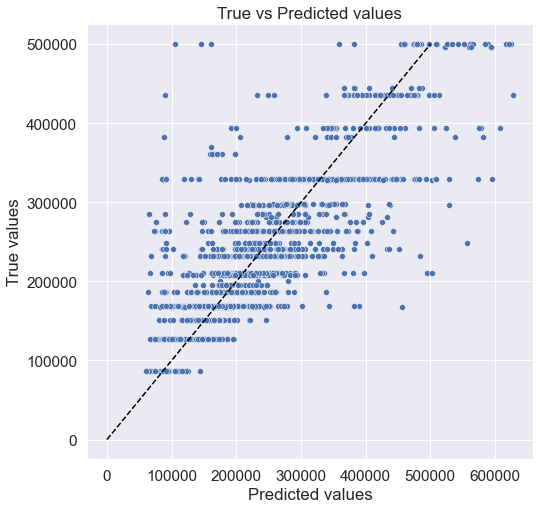

6
R2:	0.655



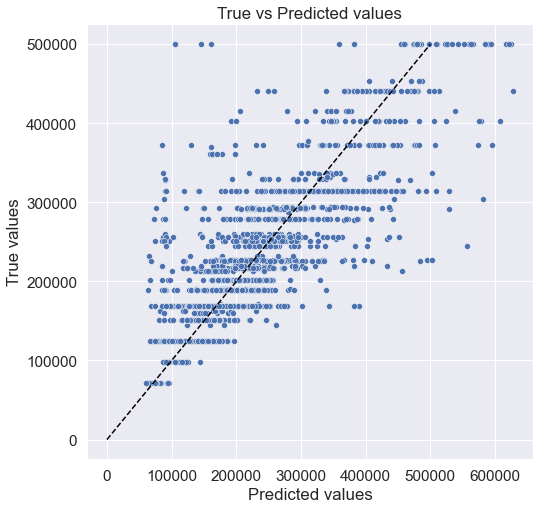

7
R2:	0.643



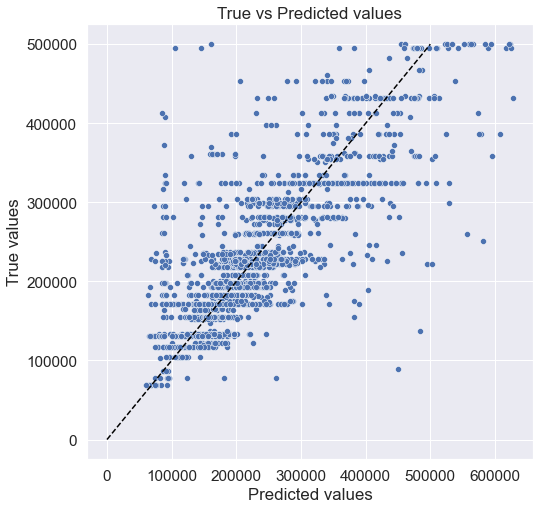

8
R2:	0.588



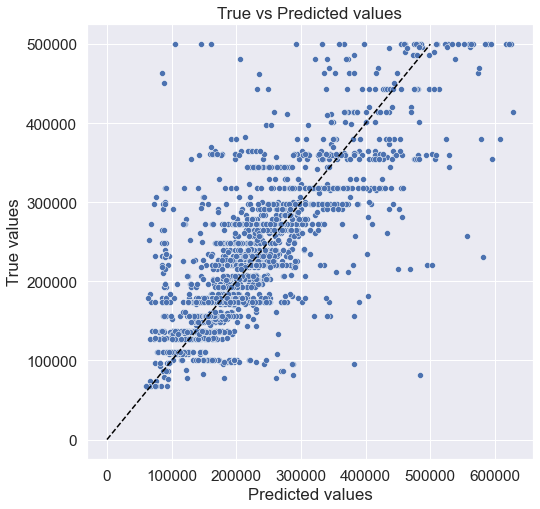

9
R2:	0.558



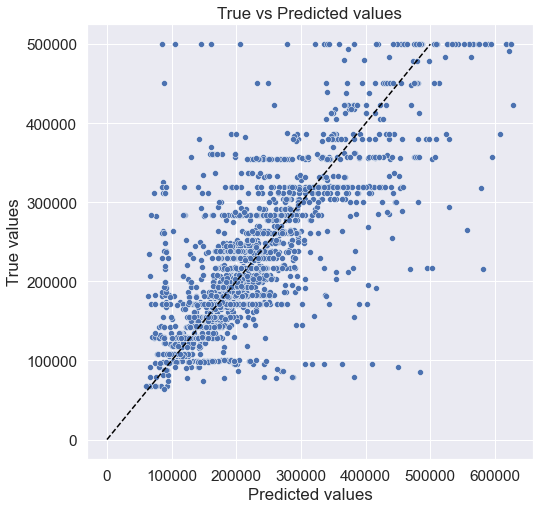

10
R2:	0.521



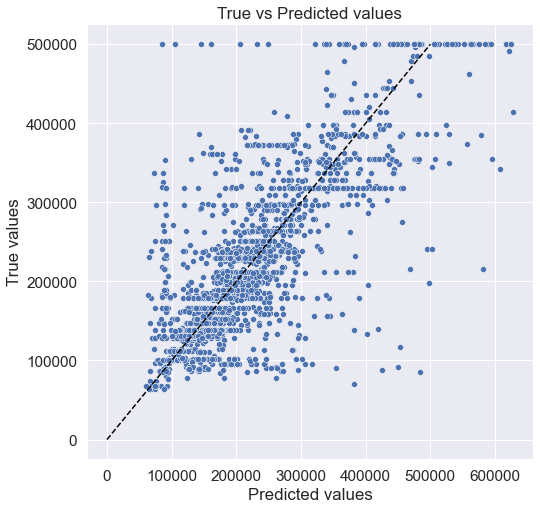

11
R2:	0.475



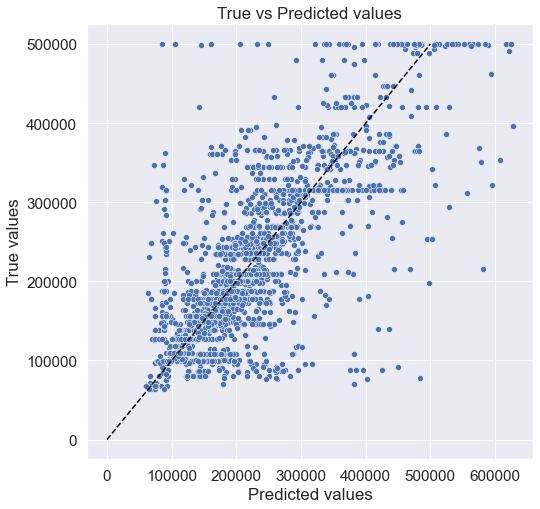

12
R2:	0.441



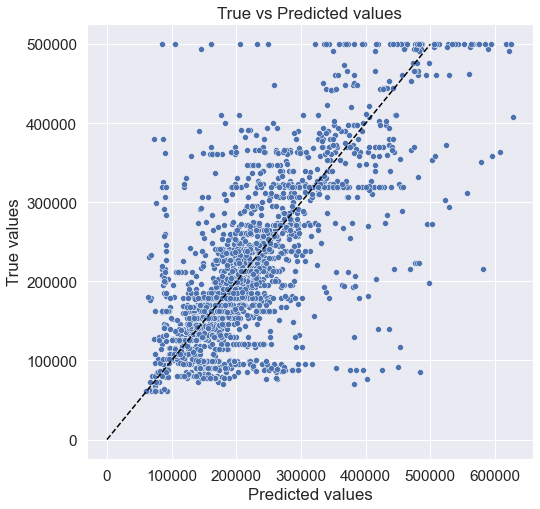

13
R2:	0.437



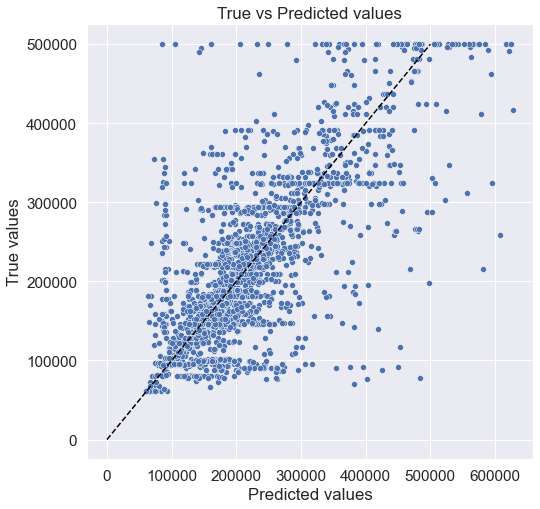

14
R2:	0.389



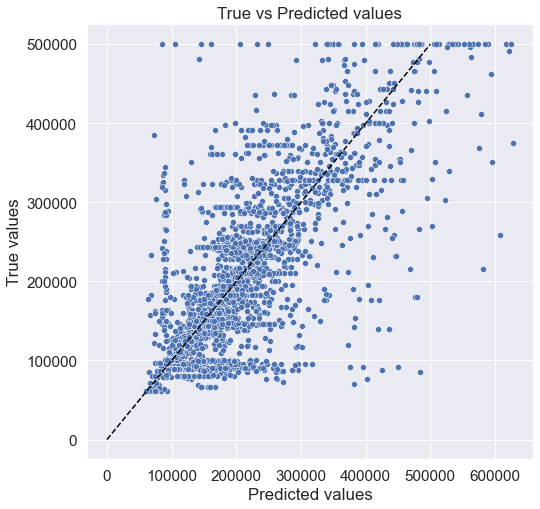

15
R2:	0.417



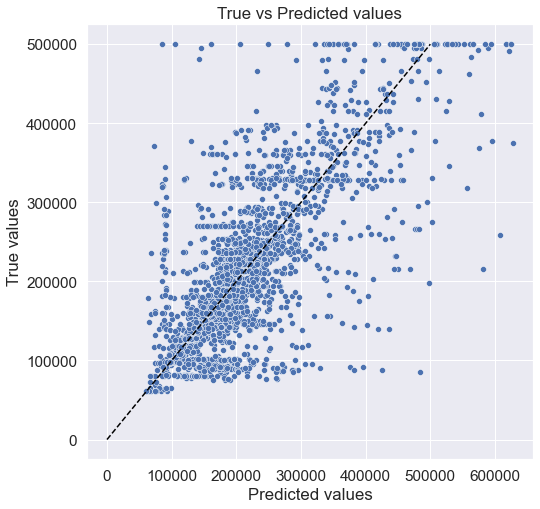

16
R2:	0.404



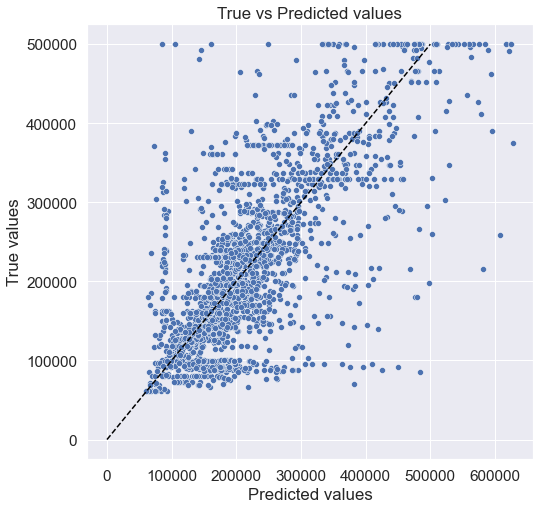

17
R2:	0.364



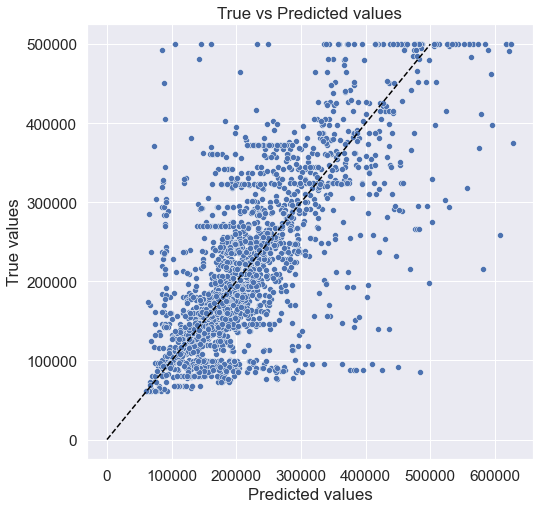

18
R2:	0.365



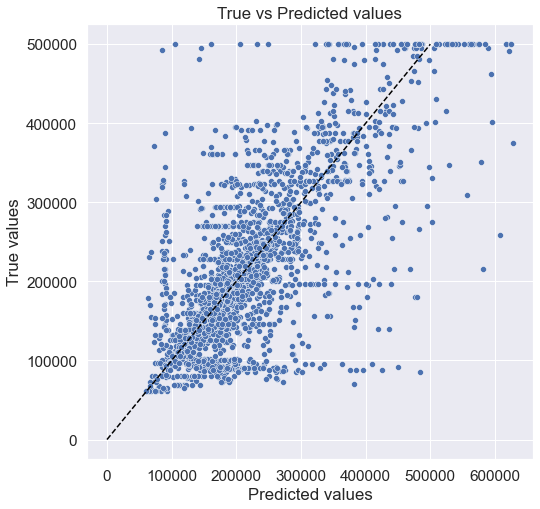

19
R2:	0.386



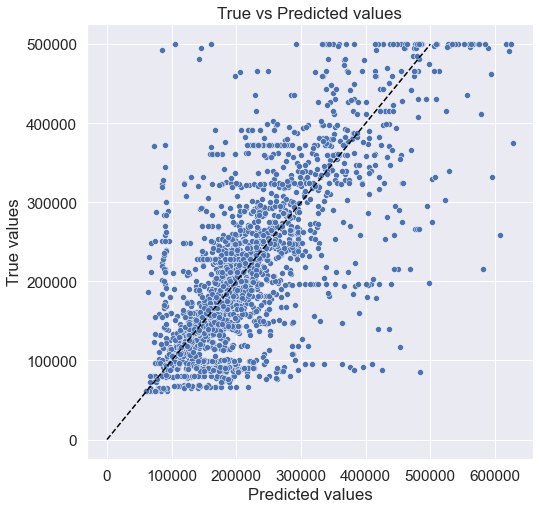

20
R2:	0.355



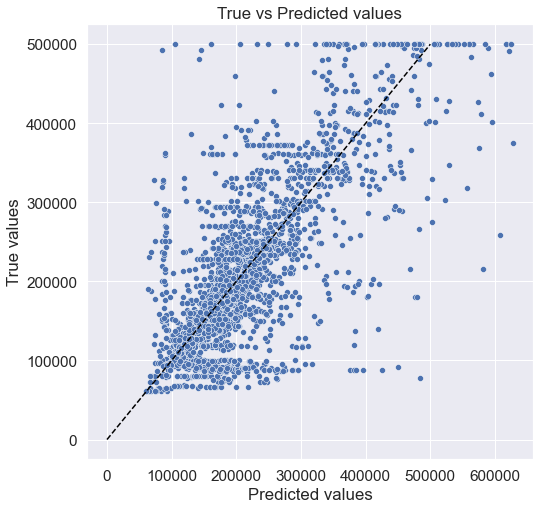

21
R2:	0.358



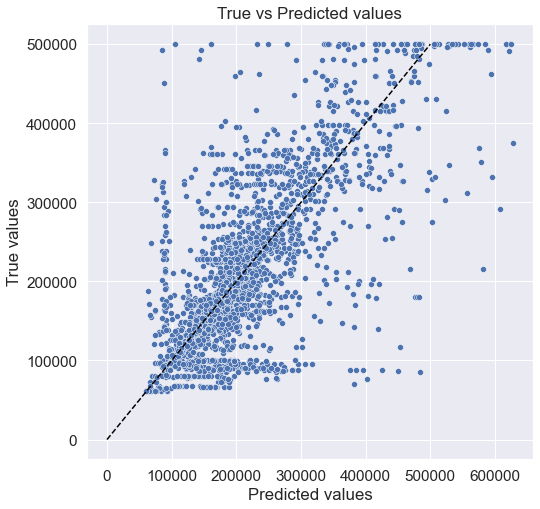

22
R2:	0.36



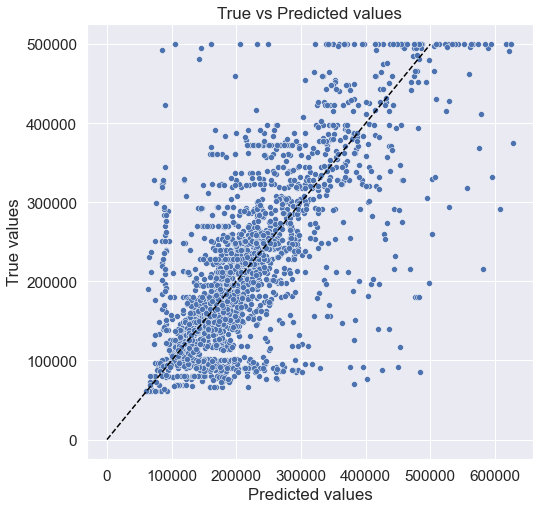

23
R2:	0.405



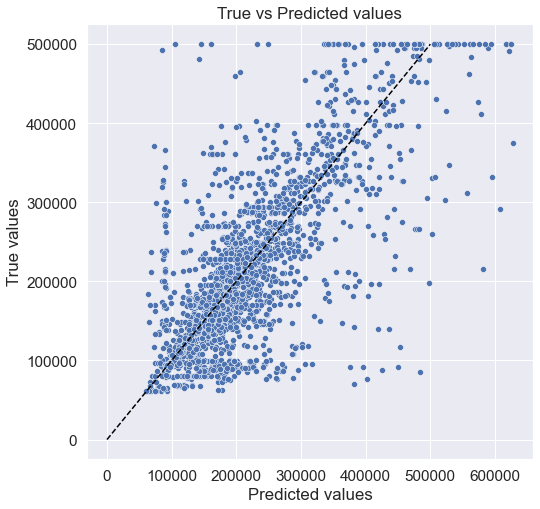

24
R2:	0.402



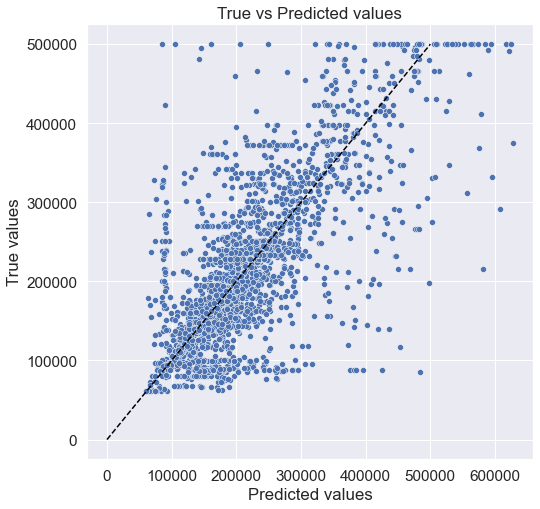

25
R2:	0.365



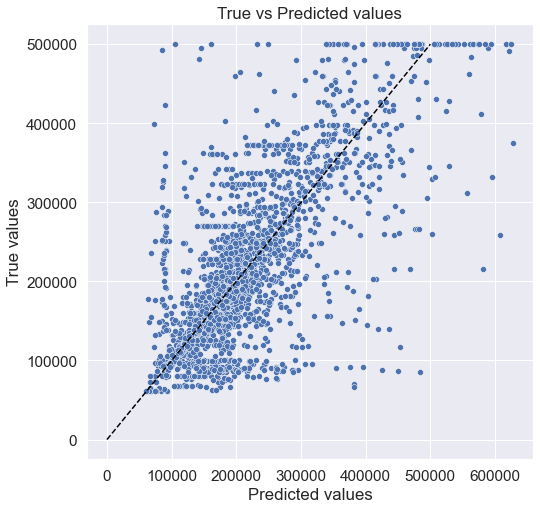

26
R2:	0.372



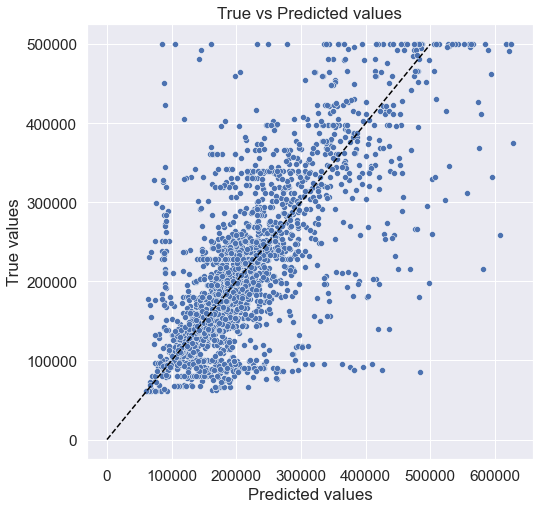

27
R2:	0.391



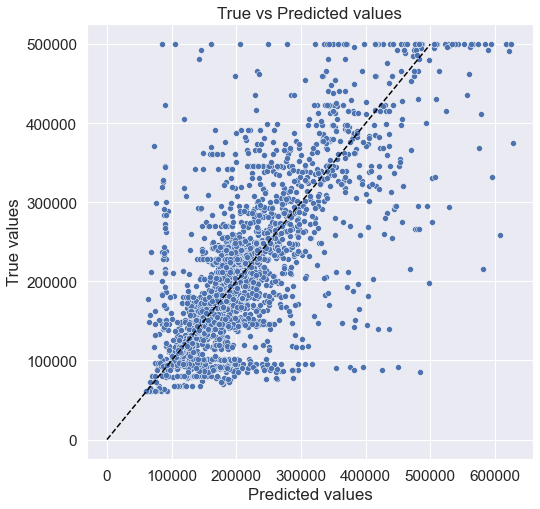

28
R2:	0.372



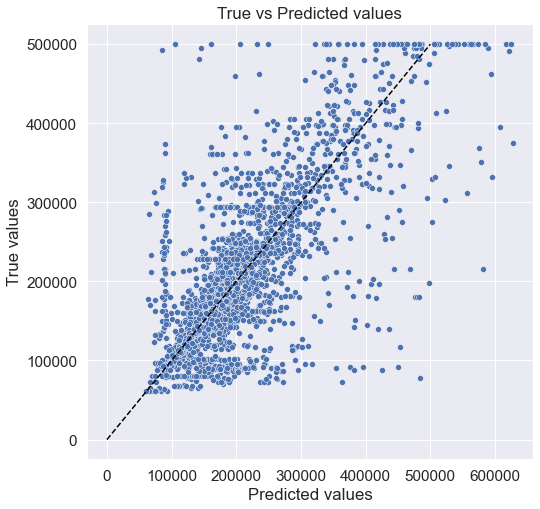

29
R2:	0.387



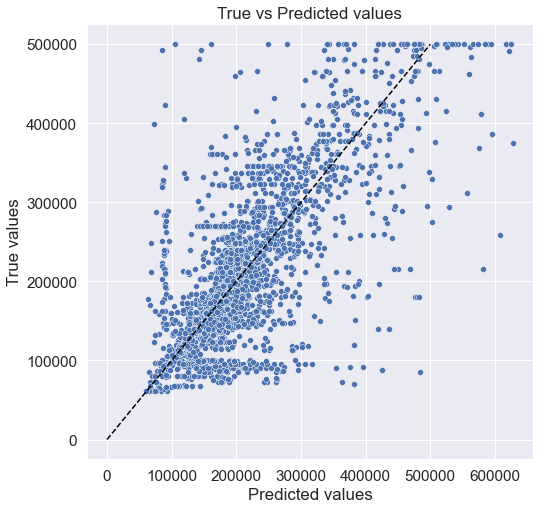

30
R2:	0.379



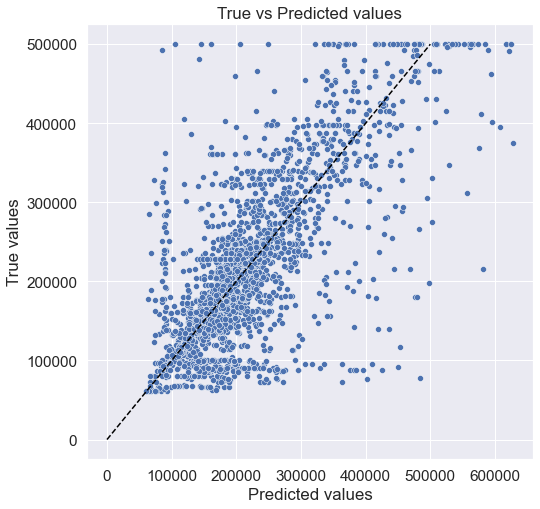

31
R2:	0.38



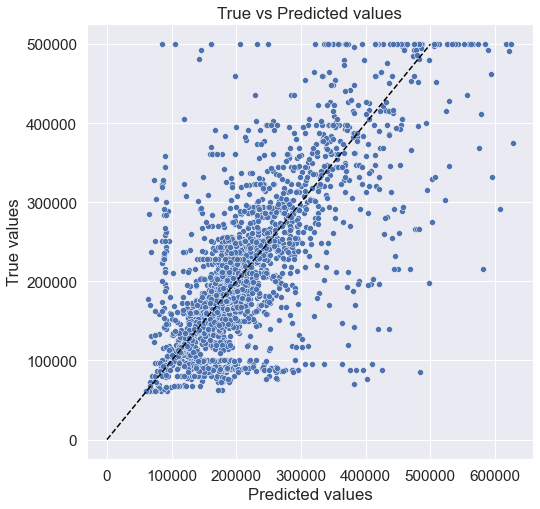

32
R2:	0.387



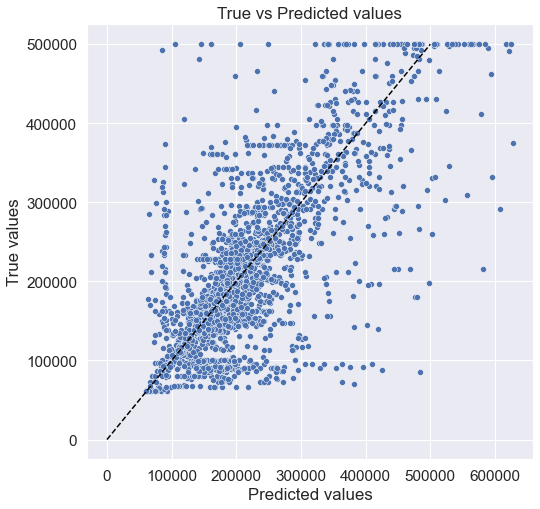

33
R2:	0.394



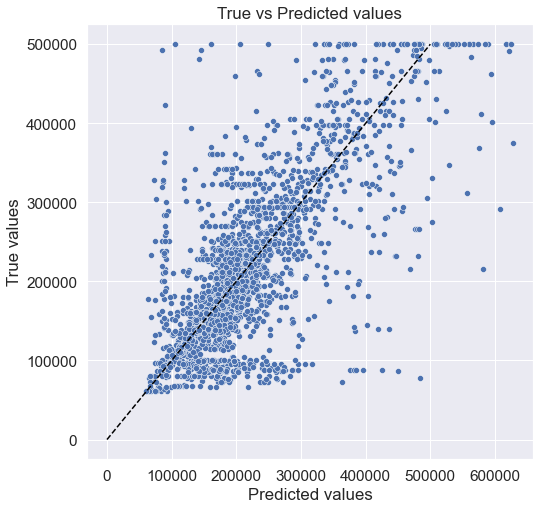

34
R2:	0.39



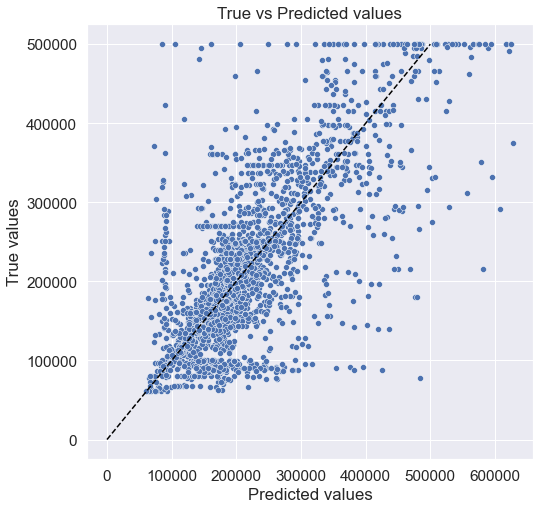

35
R2:	0.392



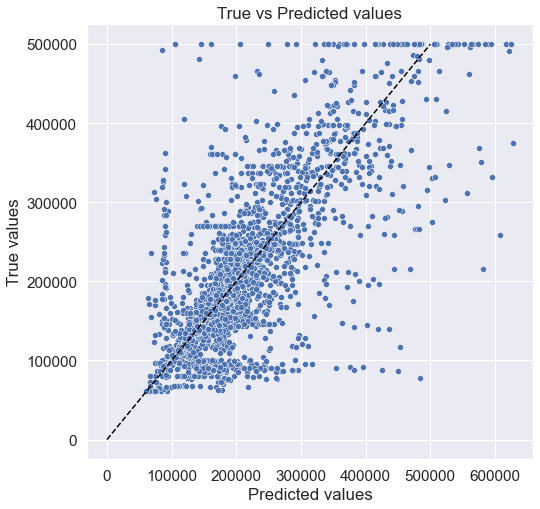

36
R2:	0.414



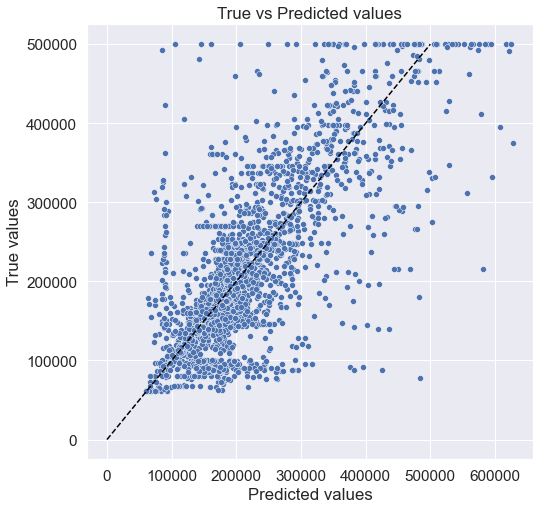

37
R2:	0.403



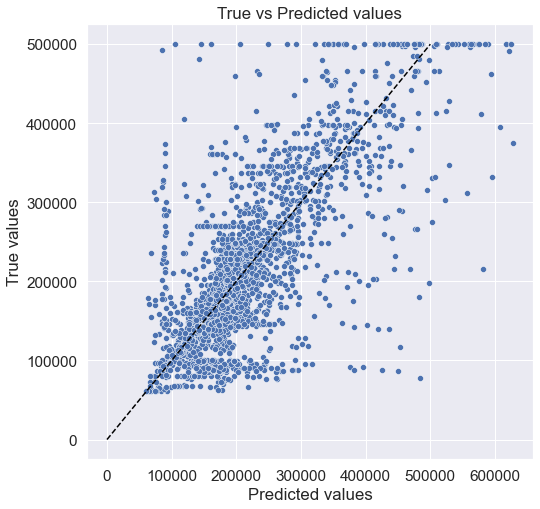

38
R2:	0.414



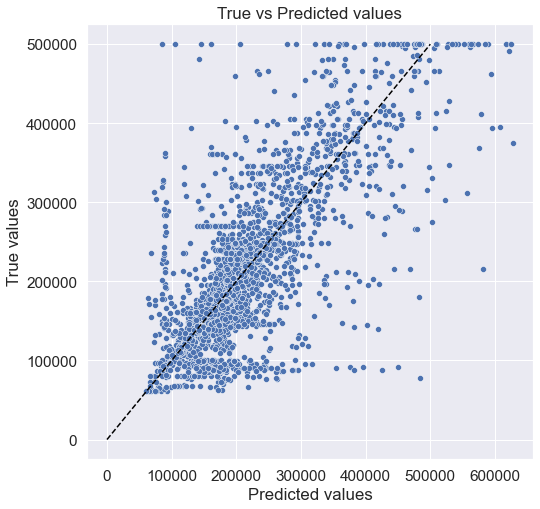

39
R2:	0.393



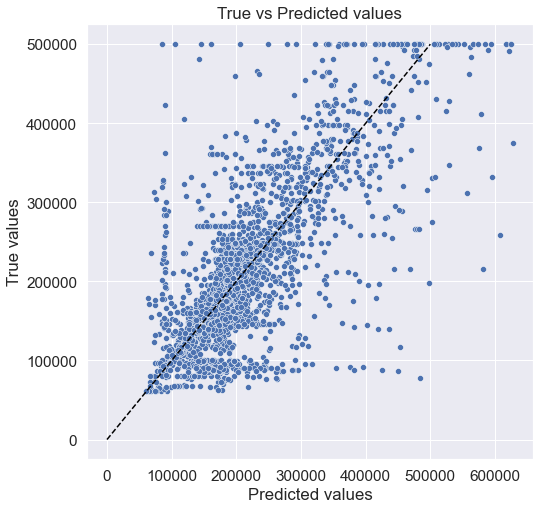

In [111]:
look_for_best_depth = {}

for n in range(2, 40):
    print(n)
    dt_model = DecisionTreeRegressor(max_depth=n, random_state=42)    

    
    look_for_best_depth[check_model(dt_model, \
                                   feature_names_all, \
                                   X_train_scaled, \
                                   y_train, \
                                   X_test_scaled, \
                                   y_test)] = n





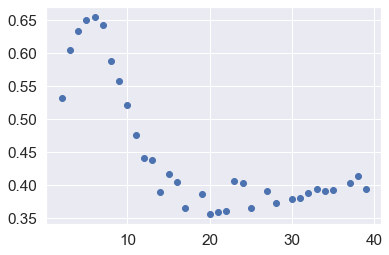

In [112]:
plt.scatter(look_for_best_depth.values(), look_for_best_depth.keys())
plt.show()

In [113]:
max_r2 = max(look_for_best_depth.keys())
max_r2

0.655

In [114]:
n = look_for_best_depth[max_r2]
n

6

R2:	0.655



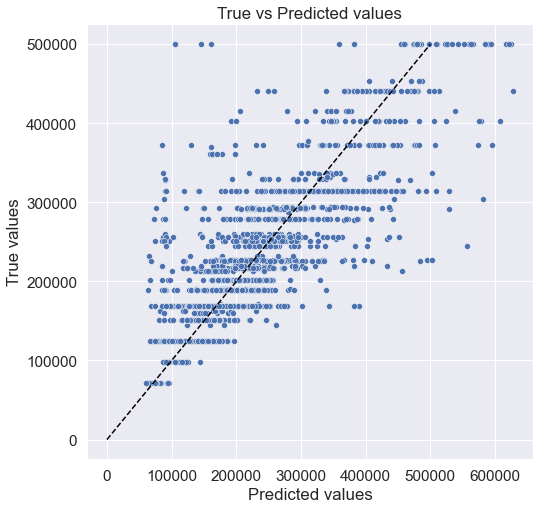

In [115]:
dt_model = DecisionTreeRegressor(max_depth=n, random_state=42) 

results_r2['dt_model'] = check_model(dt_model, \
                                   feature_names_all, \
                                   X_train_scaled, \
                                   y_train, \
                                   X_test_scaled, \
                                   y_test)

In [116]:
results_r2

lr_model  rf_moel  lr_model_2  lasso  ridge  dt_model
0      0.69        0        0.69   0.69   0.69     0.655

<h6>RandomForest</h6>

2
R2:	0.58



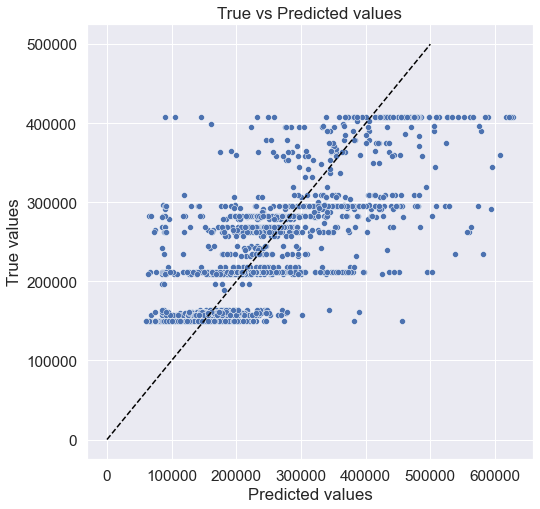

3
R2:	0.639



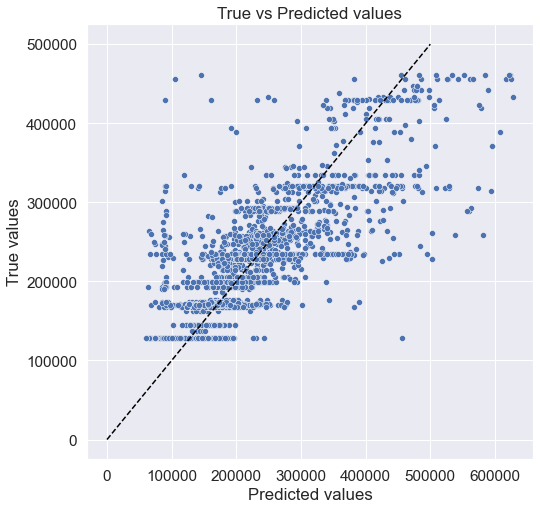

4
R2:	0.678



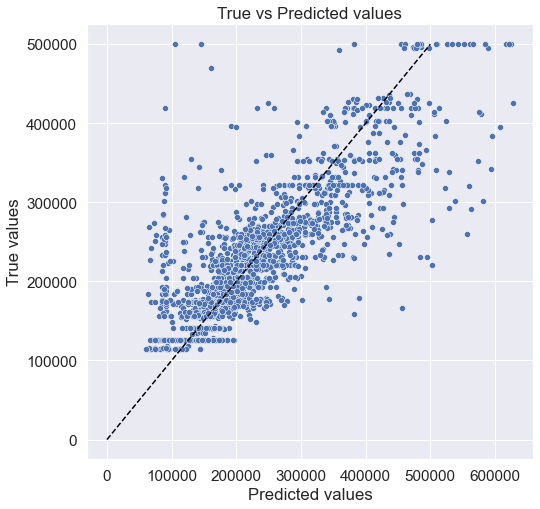

5
R2:	0.701



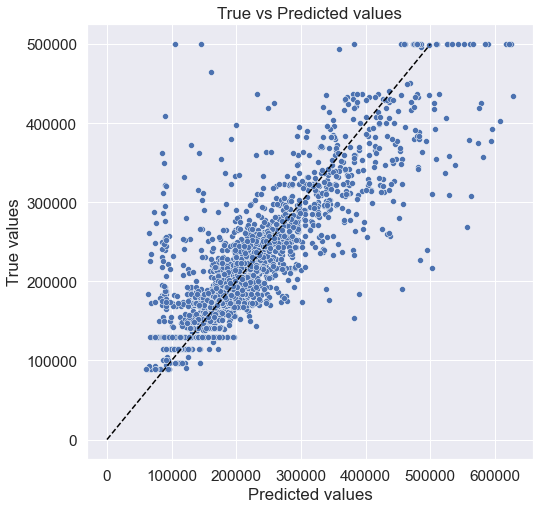

6
R2:	0.712



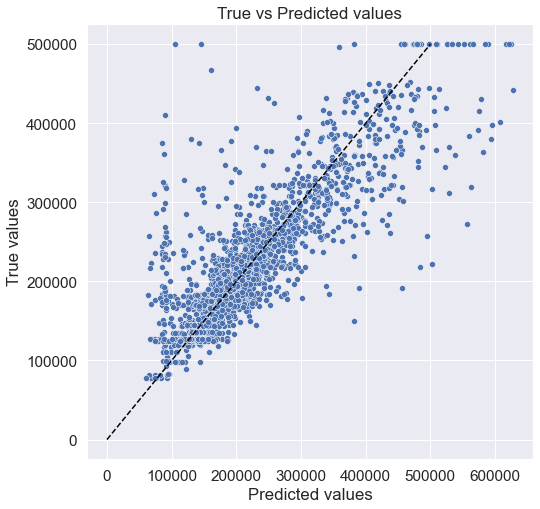

7
R2:	0.717



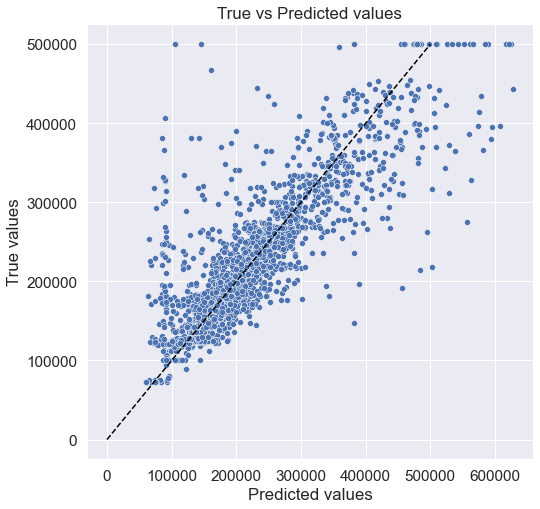

8
R2:	0.72



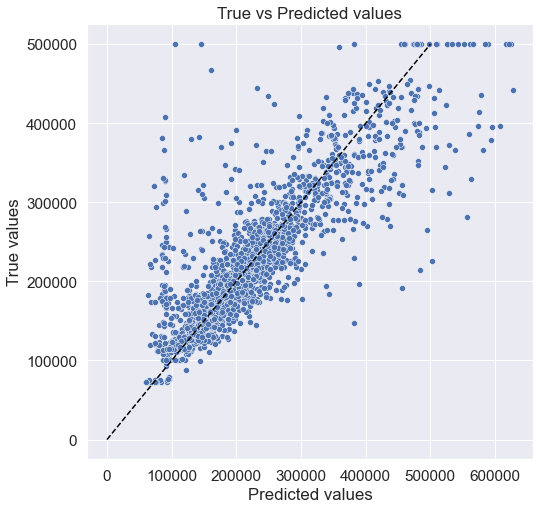

9
R2:	0.722



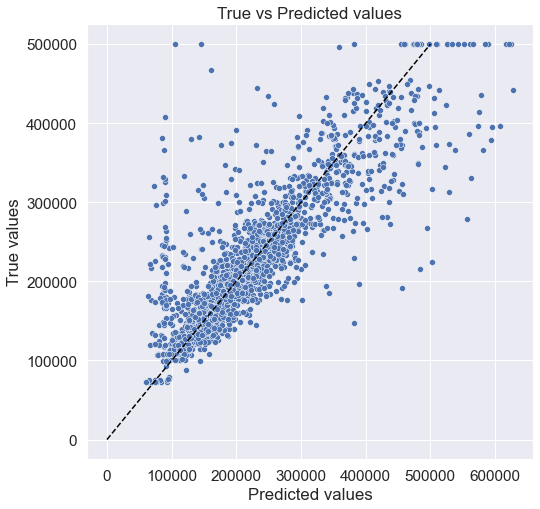

10
R2:	0.722



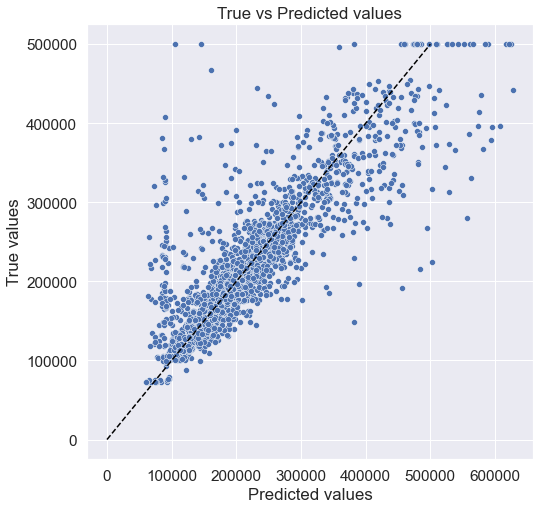

11
R2:	0.723



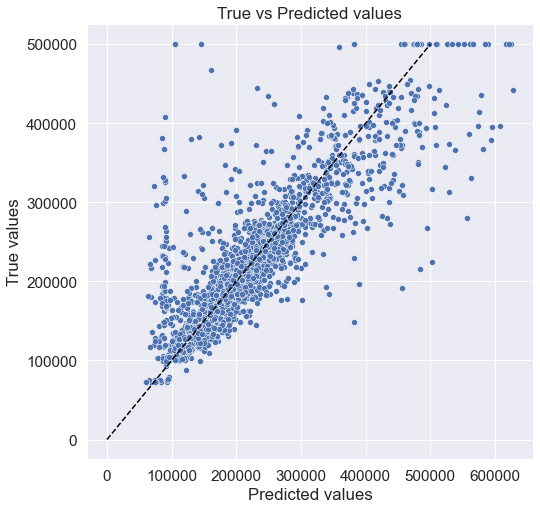

12
R2:	0.723



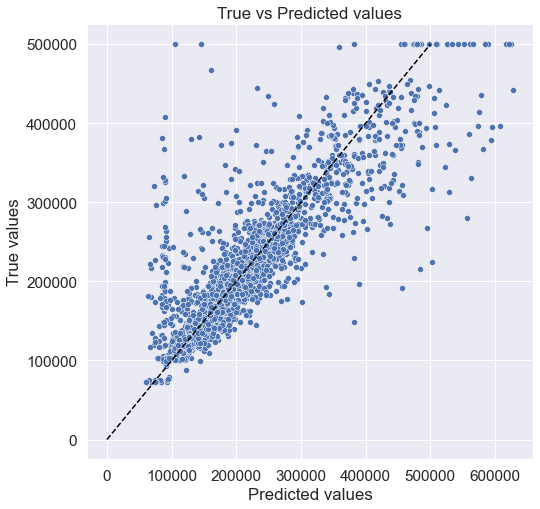

13
R2:	0.723



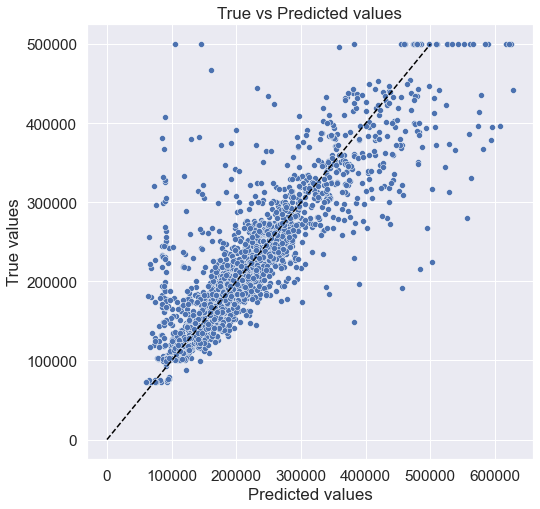

14
R2:	0.723



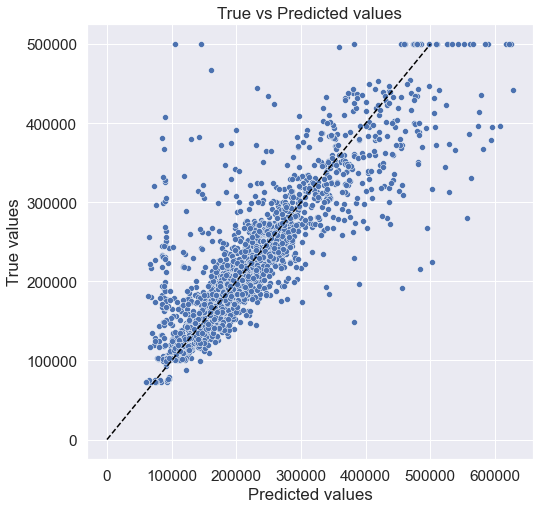

15
R2:	0.723



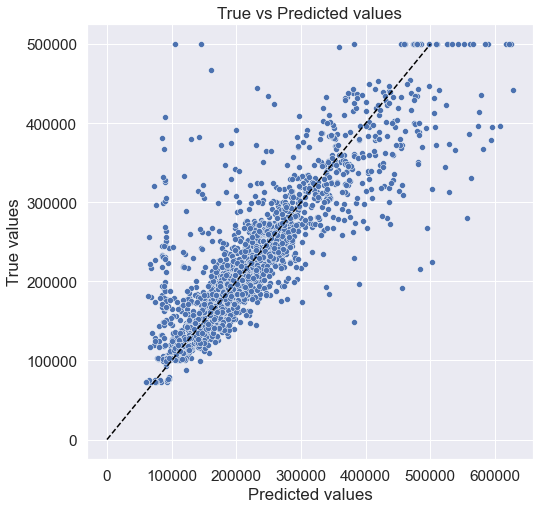

16
R2:	0.723



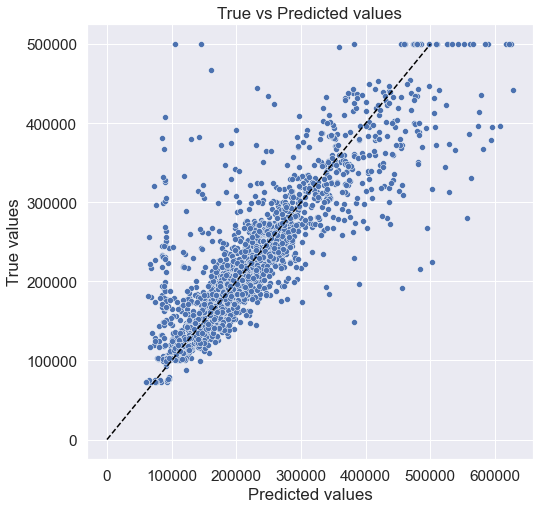

17
R2:	0.723



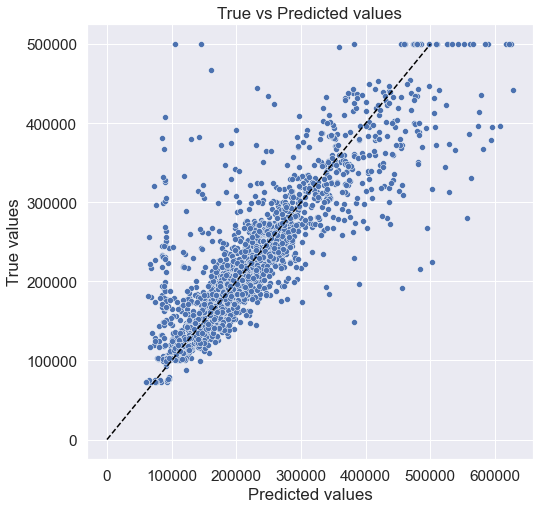

18
R2:	0.723



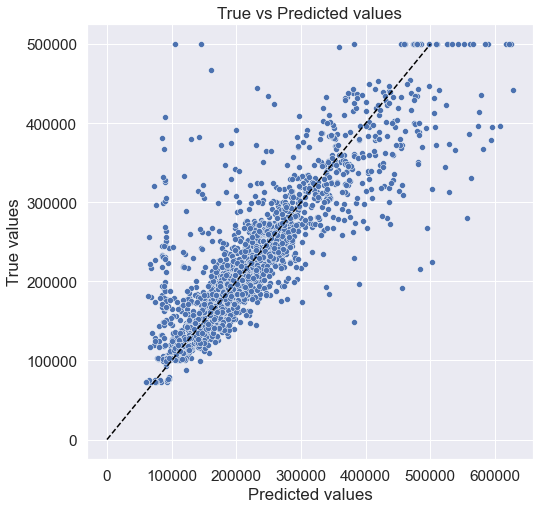

19
R2:	0.723



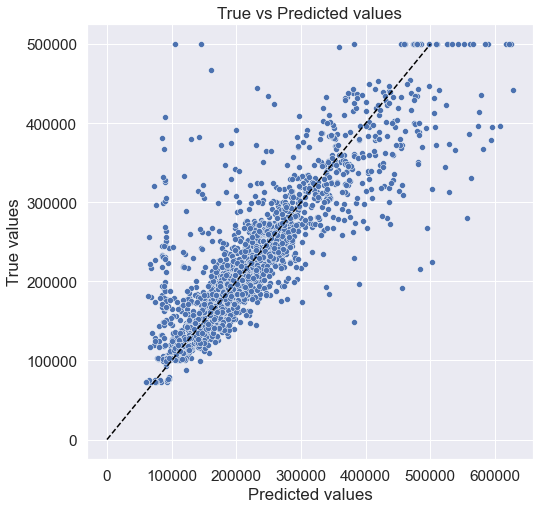

In [117]:
look_for_best_depth = {}

for n in range(2, 20):
    print(n)

    rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=n, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=25  # кол-во деревьев
                                 )

        
    look_for_best_depth[check_model(rf_model, \
                                   feature_names_all, \
                                   X_train_scaled, \
                                   y_train, \
                                   X_test_scaled, \
                                   y_test)] = n

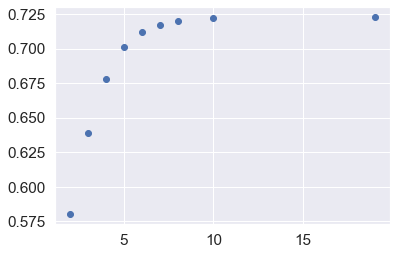

In [118]:
plt.scatter(look_for_best_depth.values(), look_for_best_depth.keys())


максимальное значение при n = 10

R2:	0.722



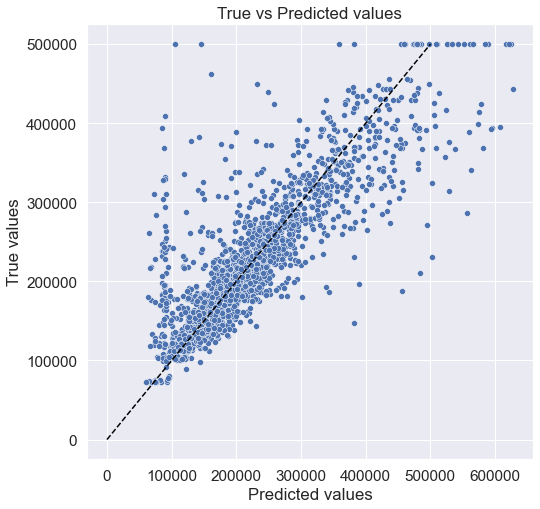

In [119]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )
results_r2['rf_model'] = check_model(rf_model, \
                                   feature_names_all, \
                                   X_train_scaled, \
                                   y_train, \
                                   X_test_scaled, \
                                   y_test)

In [120]:
results_r2

lr_model  rf_moel  lr_model_2  lasso  ridge  dt_model  rf_model
0      0.69        0        0.69   0.69   0.69     0.655     0.722

In [121]:
results_r2.drop('rf_moel', axis=1, inplace=True)

<h6>GradientBoosting</h6>

2
R2:	0.73



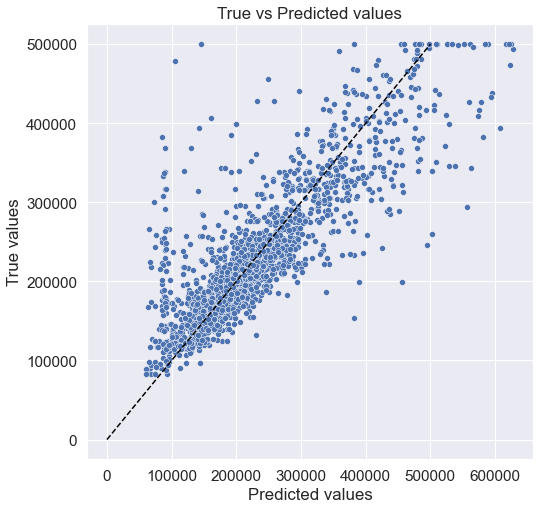

3
R2:	0.737



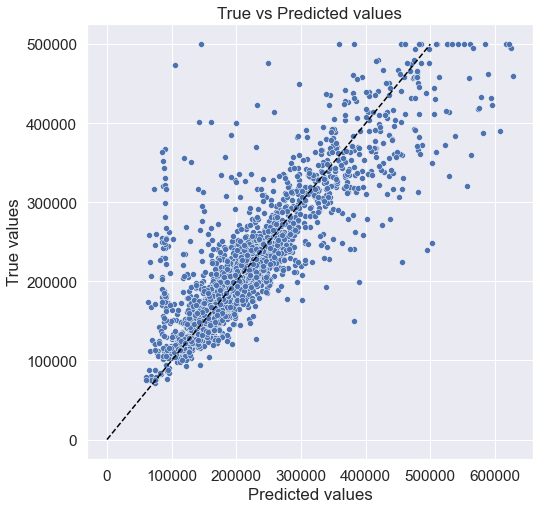

4
R2:	0.723



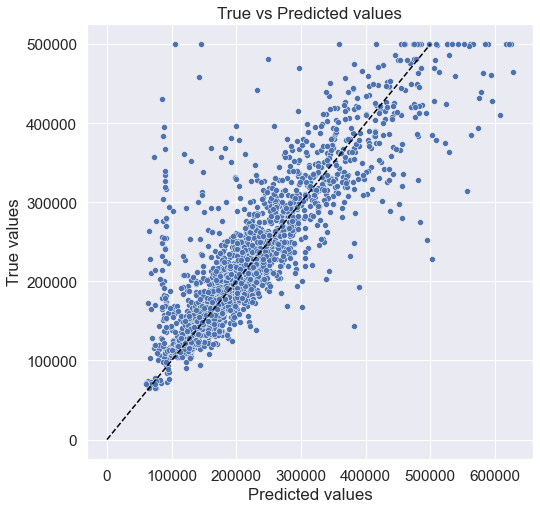

5
R2:	0.737



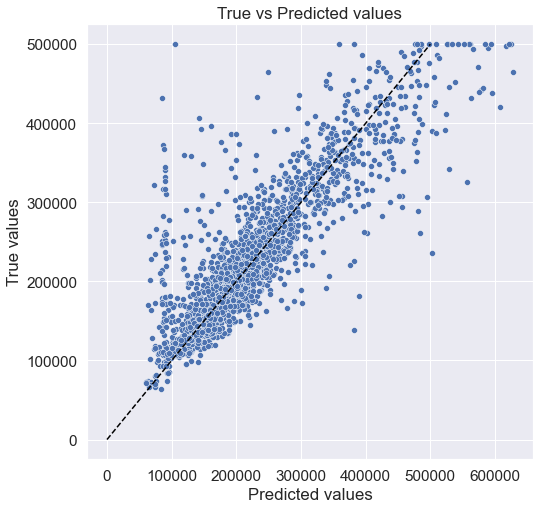

6
R2:	0.738



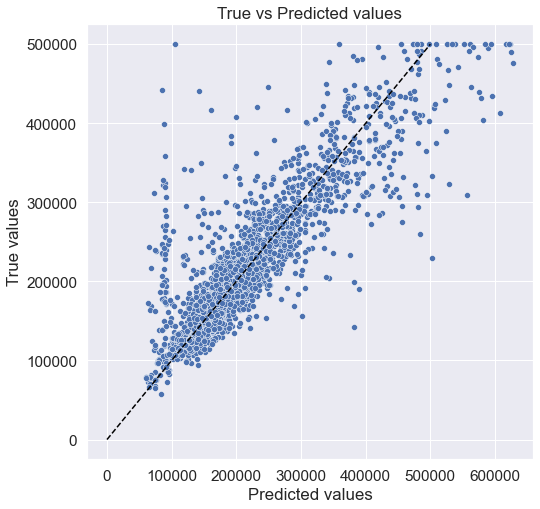

7
R2:	0.725



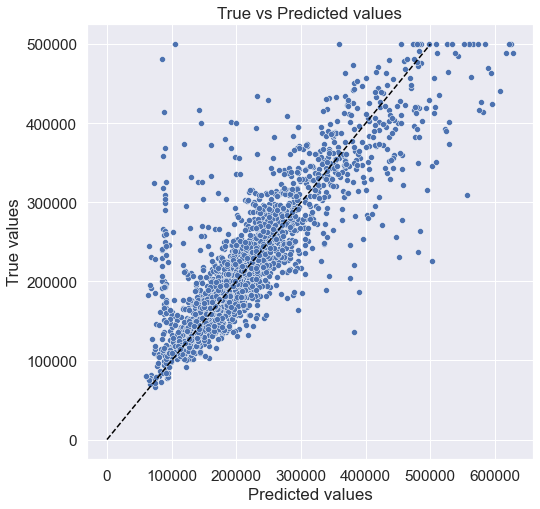

8
R2:	0.717



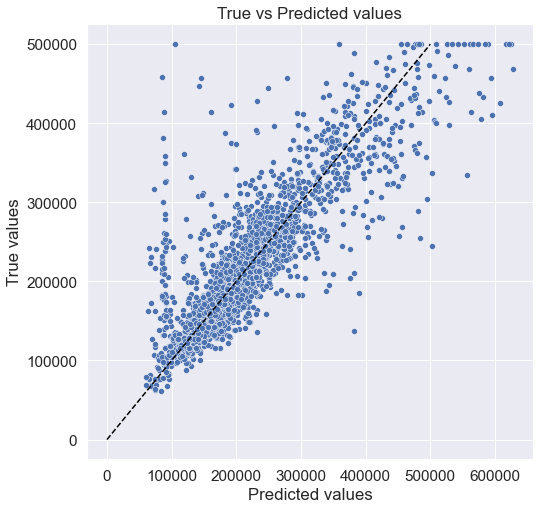

9
R2:	0.724



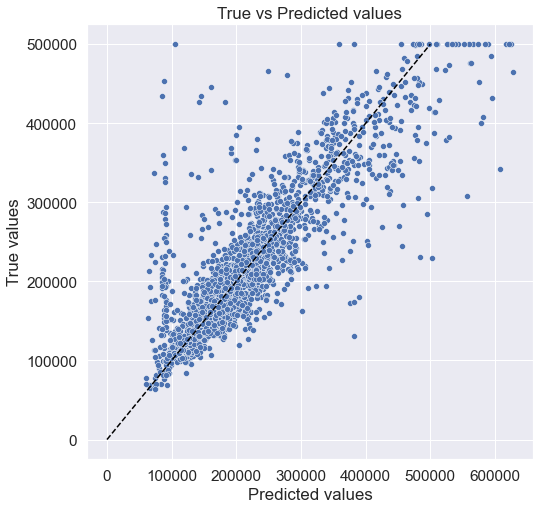

10
R2:	0.71



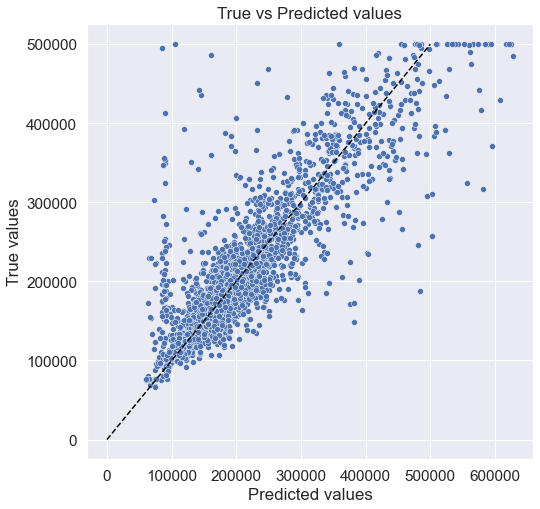

11
R2:	0.696



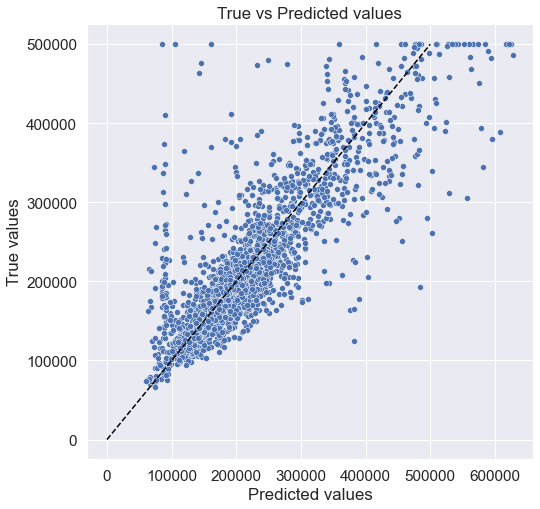

12
R2:	0.695



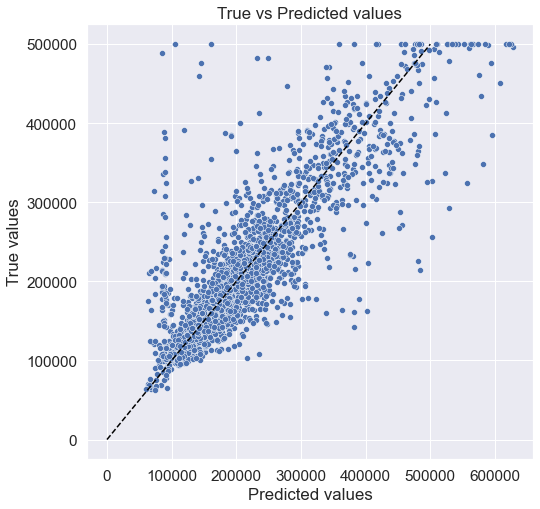

13
R2:	0.686



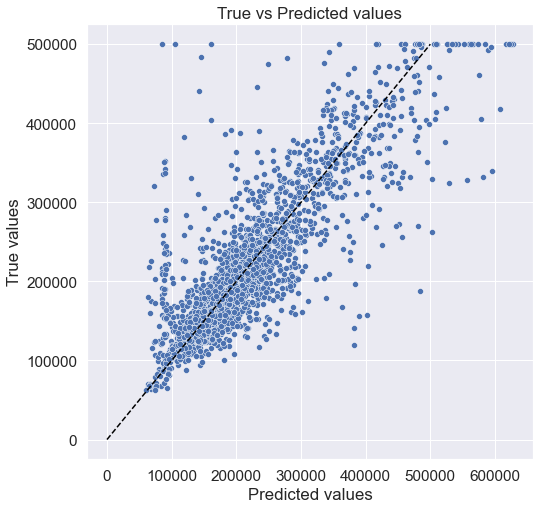

14
R2:	0.653



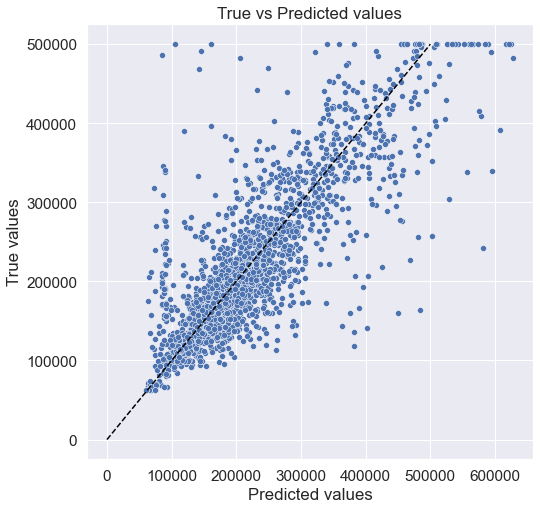

In [122]:
look_for_best_depth = {}

for n in range(2, 15):
    print(n)
    gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=n,
                                     min_samples_leaf=1,
                                     random_state=42,  
                                     n_estimators=100)

        
    look_for_best_depth[check_model(gb_model, \
                                   feature_names_all, \
                                   X_train_scaled, \
                                   y_train, \
                                   X_test_scaled, \
                                   y_test)] = n

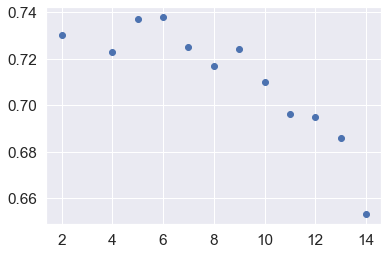

In [123]:
plt.scatter(look_for_best_depth.values(), look_for_best_depth.keys())


In [124]:
look_for_best_depth[max(look_for_best_depth.keys())]

6

R2:	0.738



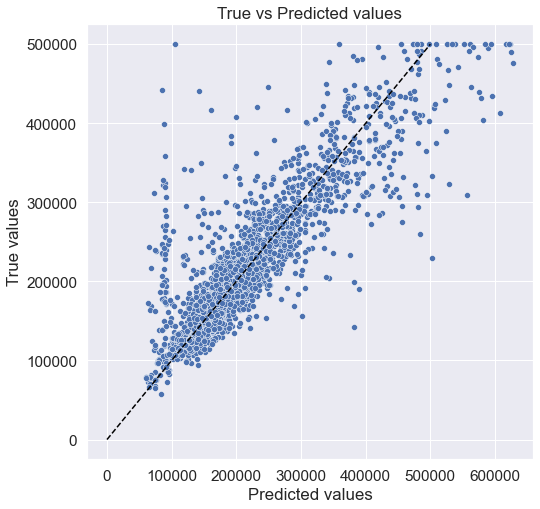

In [125]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=1,
                                     random_state=42,  
                                     n_estimators=100)

results_r2['gb_model'] = check_model(gb_model, \
                                   feature_names_all, \
                                   X_train_scaled, \
                                   y_train, \
                                   X_test_scaled, \
                                   y_test)

In [126]:
results_r2

lr_model  lr_model_2  lasso  ridge  dt_model  rf_model  gb_model
0      0.69        0.69   0.69   0.69     0.655     0.722     0.738

### Финальная модель

<hr>
<h3 style="text-align: center"> Функции для обработки данных </h3>
<hr>

Данные функции нужны чтобы не делать кучу ячеек для обработки тестовой выборки. а сделать только одну.
по уму, нужно бы с помощью этих функций нужно бы и тренировочную выборку обрабатывать, но так как весь код уже написан в других ячейках более развернуто, то я не буду их удалять и оставлю обработку тренировочной выборки как есть

In [127]:
# #обработка выбросов
# def extremum_handler(data, features = []):
#     #------------------------------------------
#     #   Rooms 
#     #------------------------------------------
#     print('Прверка стобца Rooms:')
#     print('-'*30)
    
#     rooms_count = data['Rooms'].value_counts()
#     print("data['Rooms'].value_counts():")
#     print(rooms_count)

#     #ради интереса такая картинка.
#     plt.pie(data['Rooms'].value_counts(), 
#             labels=data['Rooms'].value_counts().index.to_list(), autopct='%1.1f%%')
#     plt.title("распределение комнат")
#     plt.show()
    
#     data.loc[data['Rooms'].isin([0, 10, 19]), 'Rooms'] = data['Rooms'].median()
    
#     #------------------------------------------
#     #   Square
#     #------------------------------------------
#     print('Прверка стобца Square:')
#     print('-'*30)
#     print("data['Square'].value_counts().sort_index():")
#     square_count = data['Square'].value_counts().sort_index()
#     print(rooms_count)
    
#     data = data[(data['Square'].isnull()) |
#          (data['Square'] < data['Square'].quantile(0.975)) |
#          (data['Square'] > data['Square'].quantile(0.025)) ]

#     #------------------------------------------
#     #   LifeSquare
#     #------------------------------------------
#     print('Прверка стобца LifeSquare:')
#     print('-'*30)    
#     print("data['LifeSquare'].value_counts().sort_index():")
#     lifeSquare_count = data['LifeSquare'].value_counts().sort_index()
#     print(lifeSquare_count)

#     data = data[(data['LifeSquare'].isnull()) |
#          (data['LifeSquare'] < data['LifeSquare'].quantile(0.975)) |
#          (data['LifeSquare'] > data['LifeSquare'].quantile(0.025)) ]    
    
#     #------------------------------------------
#     #   KitchenSquare
#     #------------------------------------------
#     data = data[(data['KitchenSquare'].isnull()) |
#          (data['KitchenSquare'] < data['KitchenSquare'].quantile(0.975))] # |
#          #(df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(0.025)) ]    
#     data.loc[data['KitchenSquare']<3, ['KitchenSquare']] = 3

#     #------------------------------------------
#     #   HouseFloor & Floor
#     #------------------------------------------    
#     data['HouseFloor'][data['HouseFloor'] == 0] = data['HouseFloor'].median()    

#     floor_higher_housefloor = data.loc[data['Floor'] > data['HouseFloor']].index
#     data.loc[floor_higher_housefloor, 'Floor'] = data.loc[floor_higher_housefloor, 'HouseFloor'].apply(lambda x: random.randint(1,x))
    
#     #------------------------------------------
#     #   HouseYear
#     #------------------------------------------    
#     data['HouseYear'][data['HouseYear'] > 2022] = 2022

In [128]:
# #обработка нулевый данных (функция исключительно для имеющихся данных и не универсальная)
# def null_data_handler(data, features = []):
    
#     #LifeSquare
    
#     square_diff_mediana = (data['Square'][data['LifeSquare'].notnull()]
#                        - data['LifeSquare'][data['LifeSquare'].notnull()]
#                        - data['KitchenSquare'][data['LifeSquare'].notnull()]).median()

#     data['LifeSquare'][data['LifeSquare'].isnull()] = data['Square'][data['LifeSquare'].isnull()] -\
#                                                           data['KitchenSquare'][data['LifeSquare'].isnull()] - \
#                                                           square_diff_mediana

#     data['Healthcare_1'][data['Healthcare_1'].isnull()] = data['Healthcare_1'].median()    

In [129]:
# #Создание новых признаков
# def create_new_features(data, features = []):
#     #'Ecology_2', 'Ecology_3', 'Shops_2'
#     data['Ecology_2_bin'] = data['Ecology_2'].replace({'A': 0, 'B': 1})
#     data['Ecology_3_bin'] = data['Ecology_3'].replace({'A': 0, 'B': 1})
#     data['Shops_2_bin'] = data['Shops_2'].replace({'A': 0, 'B': 1})    
    
#     distict_size = data['DistrictId'].value_counts().reset_index().\
#                                         rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    
#     data = data.merge(distict_size, on='DistrictId', how='left')

#     data['IsDistrictLarge'] = (data['DistrictSize']>100).astype(int)
    

# #     median_price_by_district = data.groupby(['DistrictId','Rooms'], as_index=False).agg({'Price':'median'})\
# #                             .rename(columns={'Price':'MedianPriceByDistric'})    

#     data = data.merge(df_train['DistrictId', 'Rooms', 'MedianPriceByDistric'], on=['DistrictId', 'Rooms'], how='left')
    
# #     median_price_by_square = data.groupby(['Square'], as_index=False).agg({'Price':'median'})\
# #                             .rename(columns={'Price':'MedianPriceBySquare'})
    
# #     df_test = df_test.merge(median_price_by_square, on=['Square'], how='left')
# #     df_test.head()

In [130]:
results_r2[results_r2 == results_r2.loc[0,:].max()].columns

Index(['lr_model', 'lr_model_2', 'lasso', 'ridge', 'dt_model', 'rf_model',
       'gb_model'],
      dtype='object')

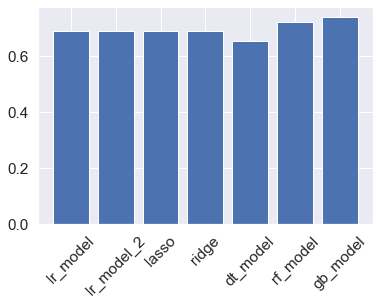

In [131]:
plt.bar(results_r2.columns, results_r2.loc[0,:])
plt.xticks(rotation=45)
plt.show()

In [132]:
final_model = gb_model

In [133]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           5000 non-null   object 
 1   DistrictId                   5000 non-null   object 
 2   Rooms                        5000 non-null   float64
 3   Square                       5000 non-null   float64
 4   LifeSquare                   5000 non-null   float64
 5   KitchenSquare                5000 non-null   float64
 6   Floor                        5000 non-null   int64  
 7   HouseFloor                   5000 non-null   float64
 8   HouseYear                    5000 non-null   int64  
 9   Ecology_1                    5000 non-null   float64
 10  Ecology_2                    5000 non-null   object 
 11  Ecology_3                    5000 non-null   object 
 12  Social_1                     5000 non-null   int64  
 13  Social_2          

In [134]:
df_test.isnull().sum()

Id                              0
DistrictId                      0
Rooms                           0
Square                          0
LifeSquare                      0
KitchenSquare                   0
Floor                           0
HouseFloor                      0
HouseYear                       0
Ecology_1                       0
Ecology_2                       0
Ecology_3                       0
Social_1                        0
Social_2                        0
Social_3                        0
Healthcare_1                    0
Helthcare_2                     0
Shops_1                         0
Shops_2                         0
Ecology_2_bin                   0
Ecology_3_bin                   0
Shops_2_bin                     0
DistrictSize                    8
IsDistrictLarge                 0
MedianPriceByDistric           67
one_meter_price_by_district    67
dtype: int64

оказались незаполненные данные. видимо появились при merge. заполню их медианой


In [135]:
median_MedianPriceByDistric = df_test['MedianPriceByDistric'].median()
median_MedianPriceByDistric

197049.2310782437

In [136]:
df_test['MedianPriceByDistric'][df_test['MedianPriceByDistric'].isnull()] = median_MedianPriceByDistric

In [137]:
median_MedianPriceByDistric = df_test['MedianPriceByDistric'].median()
median_MedianPriceByDistric

197049.2310782437

In [138]:
median_one_meter_price_by_district = df_test['one_meter_price_by_district'].median()
median_one_meter_price_by_district

4091.9257864681576

In [139]:
df_test['one_meter_price_by_district'][df_test['one_meter_price_by_district'].isnull()] = median_one_meter_price_by_district

In [140]:
median_one_meter_price_by_district = df_test['one_meter_price_by_district'].median()
median_one_meter_price_by_district

4091.9257864681576

In [141]:
median_DistrictSize = df_test['DistrictSize'].median()
median_DistrictSize

97.0

In [142]:
df_test['DistrictSize'][df_test['DistrictSize'].isnull()] = median_DistrictSize

In [143]:
median_DistrictSize = df_test['DistrictSize'].median()
median_DistrictSize

97.0

In [144]:
df_test.isnull().sum()

Id                             0
DistrictId                     0
Rooms                          0
Square                         0
LifeSquare                     0
KitchenSquare                  0
Floor                          0
HouseFloor                     0
HouseYear                      0
Ecology_1                      0
Ecology_2                      0
Ecology_3                      0
Social_1                       0
Social_2                       0
Social_3                       0
Healthcare_1                   0
Helthcare_2                    0
Shops_1                        0
Shops_2                        0
Ecology_2_bin                  0
Ecology_3_bin                  0
Shops_2_bin                    0
DistrictSize                   0
IsDistrictLarge                0
MedianPriceByDistric           0
one_meter_price_by_district    0
dtype: int64

In [145]:
ytest_pred = final_model.predict(df_test.loc[:, feature_names_all])

In [146]:
ytest_pred[-5:]

array([199968.47608367, 206037.93365824, 205024.41307106, 178823.98698987,
       234308.32097511])

In [147]:
ytest_result = pd.DataFrame(ytest_pred, index=df_test['Id'], columns=['Price'])
ytest_result.reset_index(inplace=True)
ytest_result.tail()

Id          Price
4995  10379  199968.476084
4996  16138  206037.933658
4997   3912  205024.413071
4998   5722  178823.986990
4999  11004  234308.320975

In [148]:
df_test.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567         44    1.0  36.847630   19.094182            5.0      5   
1  5925         62    1.0  42.493907   42.568133           10.0      7   
2   960         27    2.0  59.463678   39.102235            9.0     19   
3  3848         23    3.0  49.646030   33.893825            6.0      2   
4   746         74    1.0  53.837056   39.475612            3.0      8   

   HouseFloor  HouseYear  Ecology_1  ... Helthcare_2 Shops_1  Shops_2  \
0         9.0       1970   0.036122  ...           1       1        B   
1        17.0       2017   0.072158  ...           0       0        A   
2        19.0       1977   0.211401  ...           0       1        B   
3         2.0       1965   0.014073  ...           0       0        B   
4        17.0       1977   0.309479  ...           0       6        B   

   Ecology_2_bin  Ecology_3_bin  Shops_2_bin  DistrictSize  IsDistrictLarge  \
0              1              1            1         104.0                1   
1              1              1            0         247.0                1   
2              1              1            1         851.0                1   
3              1              1            1         565.0                1   
4              1              1            1         114.0                1   

  MedianPriceByDistric  one_meter_price_by_district  
0        171145.169069                  4806.416257  
1        129107.218932                  2763.143194  
2        165700.355193                  2574.064003  
3        166687.735824                  2105.548938  
4        165071.825722                  3404.238545  

[5 rows x 26 columns]

In [149]:
ytest_result['Id'] = ytest_result['Id'].astype(int)

In [150]:
ytest_result.to_csv('gonin_predictions.csv', index=False, encoding='utf-8',sep=',')